In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import time


def trace_binary_path(tree, sample_leaf_index):
    children_left = tree.children_left
    children_right = tree.children_right
    node = 0
    binary_path = ''
    search = sample_leaf_index
    while True:
        i = np.where(children_left == search)[0]
        if i.size:
            binary_path = '0' + binary_path
        else:
            i = np.where(children_right == search)[0]
            binary_path = '1' + binary_path
        i = i[0]
        if i == 0:
            break
        search = i
    return binary_path

def dist(x: str, y: str):
    depth = max(len(x), len(y))
    for i in range(depth):
        if x[i] != y[i]:
            return depth - i
    return 0

def children(tree):
    children_left = tree.children_left
    children_right = tree.children_right
    print(f'left: {list(enumerate(children_left))}')
    print(f'right: {list(enumerate(children_right))}')

def print_tree(tree, index = 0, offset = 0):
    if index == -1:
        return
    print_tree(tree, tree.children_left[index], offset + 1)
    print(' ' * (2 * offset) + f'{offset}:' + str(index))
    print_tree(tree, tree.children_right[index], offset + 1)


def how_many_neighbors_for_KNN(points):
    # return len(points)
    return 5

In [2]:
t = np.linspace(0, 6 * np.pi, 500)
x = t * np.cos(t)
y = t * np.sin(t)
points = np.vstack((x, y)).T

labels = np.where(t < 2 * np.pi, 'A', 'B')

N_ESTIMATORS = 10


random_trees = RandomTreesEmbedding(n_estimators=N_ESTIMATORS, random_state=42)
encoded_points = random_trees.fit_transform(points).toarray()

binary_paths = []
for estimator in random_trees.estimators_:
    leaf_indices = estimator.apply(points).ravel()
    for leaf_index in leaf_indices:
        binary_path = trace_binary_path(estimator.tree_, leaf_index)
        binary_paths.append(binary_path)

binary_paths = np.array(binary_paths).reshape(len(random_trees.estimators_), len(points)).T
print(f'paths shape: {binary_paths.shape}')

print_tree(random_trees.estimators_[5].tree_)

num_points = len(points)
pairwise_distances = np.zeros((num_points, num_points))
for i in range(num_points):
    for j in range(i + 1, num_points):
        avg_distance = 0
        for k in range(len(random_trees.estimators_)):
            # print(i, j, k)
            try:
                avg_distance += dist(binary_paths[i][k], binary_paths[j][k])
            except IndexError as ie:
                print(ie, binary_paths[i][k], binary_paths[j][k])
                children(random_trees.estimators_[k].tree_)
                print(
                    random_trees.estimators_[k].apply([points[i], points[j]]),
                )
                raise IndexError(ie)
        avg_distance /= len(random_trees.estimators_)
        pairwise_distances[i, j] = avg_distance
        pairwise_distances[j, i] = avg_distance

# predicted_labels = []
# for i in range(num_points):
#     distances_to_A = [pairwise_distances[i, j] for j in range(num_points) if labels[j] == 'A']
#     distances_to_B = [pairwise_distances[i, j] for j in range(num_points) if labels[j] == 'B']
#     if np.mean(distances_to_A) < np.mean(distances_to_B):
#         predicted_labels.append('A')
#     else:
#         predicted_labels.append('B')

# accuracy = np.mean(np.array(predicted_labels) == labels)
# print(f"Classification Accuracy: {accuracy:.2f}")

# from sklearn.metrics import precision_score, recall_score, f1_score

# true_labels = np.array([1 if label == 'A' else 0 for label in labels])
# predicted_labels_binary = np.array([1 if label == 'A' else 0 for label in predicted_labels])
# precision = precision_score(true_labels, predicted_labels_binary, pos_label=1)
# recall = recall_score(true_labels, predicted_labels_binary, pos_label=1)
# f1 = f1_score(true_labels, predicted_labels_binary, pos_label=1)
# print(f"Precision: {precision:.2f}")
# print(f"Recall: {recall:.2f}")
# print(f"F1-Score: {f1:.2f}")

# plt.figure(figsize=(8, 8))
# plt.scatter(x, y, c=[1 if label == 'A' else 0 for label in predicted_labels], cmap='coolwarm', alpha=0.7)
# plt.title("Spiral with Points Classified as A (Red) and B (Blue)")
# plt.xlabel("X")
# plt.ylabel("Y")
# plt.colorbar(label="Classification (A/B)")
# plt.show()

paths shape: (500, 10)
          5:5
        4:4
          5:6
      3:3
          5:8
        4:7
          5:9
    2:2
        4:11
      3:10
          5:13
        4:12
          5:14
  1:1
          5:18
        4:17
          5:19
      3:16
          5:21
        4:20
          5:22
    2:15
          5:25
        4:24
          5:26
      3:23
          5:28
        4:27
          5:29
0:0
          5:34
        4:33
          5:35
      3:32
          5:37
        4:36
          5:38
    2:31
          5:41
        4:40
          5:42
      3:39
          5:44
        4:43
          5:45
  1:30
          5:49
        4:48
          5:50
      3:47
          5:52
        4:51
          5:53
    2:46
          5:56
        4:55
          5:57
      3:54
          5:59
        4:58
          5:60


## Проверка формулы расстояния

In [3]:
# a_point = np.random.randint(0, len(points))
# b_point = np.random.randint(0, len(points))
# k = np.random.randint(0, N_ESTIMATORS)
# a_point, b_point, k = 340, 209, 6
# print(f'first point: {a_point}, second point: {b_point}, tree: {k}')
# print('Tree structure:')
# print_tree(random_trees.estimators_[k].tree_)
# print('Leaves:')
# print(random_trees.estimators_[k].apply([points[a_point], points[b_point]]))
# print(f'Binary paths:\n first: {binary_paths[a_point][k]}, second: {binary_paths[b_point][k]}')

In [4]:
# def color_points_by_pairwise_distance(pairwise_distances, selected_point_index):
#     distances = pairwise_distances[selected_point_index]
#     colors = distances / np.max(distances)
#     return colors


# selected_point_index = 250

# colors = color_points_by_pairwise_distance(pairwise_distances, selected_point_index)

# plt.figure(figsize=(8, 8))
# plt.scatter(x, y, c=colors, cmap='viridis', alpha=0.7)
# plt.scatter([x[selected_point_index]], [y[selected_point_index]], c='red', s=100)
# plt.title("Spiral with Points Colored by Distance to Selected Point")
# plt.xlabel("X")
# plt.ylabel("Y")
# plt.colorbar(label="Normalized Distance")
# plt.show()

KNN Score:  0.9975
Classification Accuracy: 1.00


C:\Users\Максим\AppData\Local\Temp\ipykernel_38948\2317741587.py:102: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x[test_idx], y[test_idx], c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


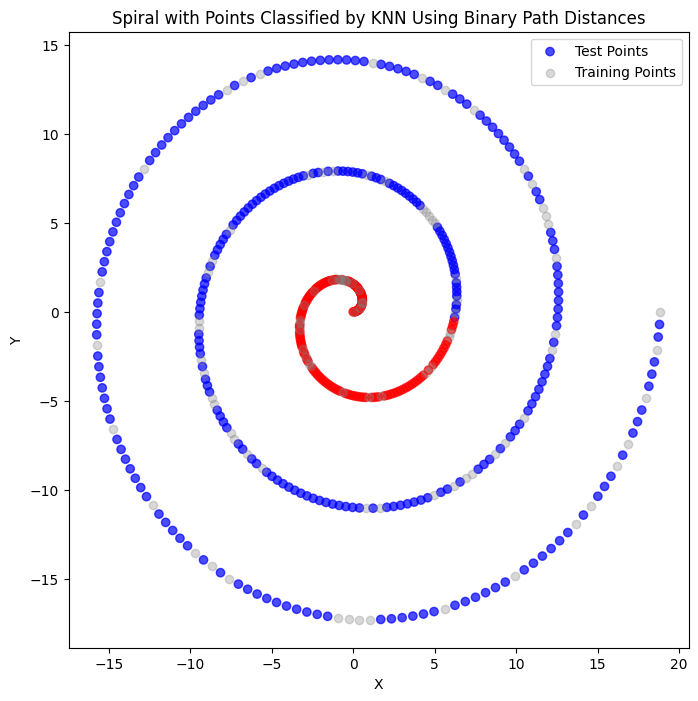

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


test_size = 0.8
num_neighbors = 5

train_idx, test_idx = train_test_split(np.arange(num_points), test_size=test_size, random_state=42)
D = pairwise_distances[:, train_idx]
train_distances = D[train_idx] 
test_distances = D[test_idx] 
train_labels = labels[train_idx]
test_labels = labels[test_idx]

knn = KNeighborsClassifier(n_neighbors=num_neighbors, metric='precomputed')
knn.fit(train_distances, train_labels)

print('KNN Score: ', knn.score(test_distances, test_labels))

predicted_labels = knn.predict(test_distances)

accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Classification Accuracy: {accuracy:.2f}")

def plot_decision_boundary(clf, X, y, title):
    h = 0.02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

# Function to visualize results
def visualize_results(X_train, X_test, y_train, y_test, predicted_labels, title):
    plt.figure(figsize=(8, 8))
    
    # Extract x and y coordinates from the test set
    x_test = X_test[:, 0]
    y_test = X_test[:, 1]
    
    # Colors for predicted labels
    colors = ['red' if label == 'A' else 'blue' for label in predicted_labels]
    
    # Plot test points with predicted labels
    plt.scatter(x_test, y_test, c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")
    
    # Plot training points in gray
    x_train = X_train[:, 0]
    y_train = X_train[:, 1]
    plt.scatter(x_train, y_train, c='gray', alpha=0.3, label="Training Points")
    
    # Add title, labels, and legend
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.show()

def other_options(points, labels, visualize = True):
    X = points
    label_encoder = LabelEncoder()
    trans_labels = label_encoder.fit_transform(labels)
    X_train, X_test, y_train, y_test = train_test_split(X, trans_labels, test_size=test_size, random_state=42)

    classifiers = {
        "Extra Trees": ExtraTreesClassifier(n_estimators=N_ESTIMATORS, random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "KNN": KNeighborsClassifier(n_neighbors=num_neighbors),
        "SVM": SVC(kernel='rbf', random_state=42)
    }

    results = {}
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = accuracy
        print(f"{name} Accuracy: {accuracy:.4f}")
    results = {}
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        predicted_labels = label_encoder.inverse_transform(y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = accuracy
        print(f"{name} Accuracy: {accuracy:.4f}")
        visualize_results(X_train, X_test, y_train, y_test, predicted_labels, title=f"Spiral Classified by {name}")

# other_options(points, labels)


# y = label_encoder.inverse_transform(y)
plt.figure(figsize=(8, 8))
colors = ['red' if label == 'A' else 'blue' for label in predicted_labels]
plt.scatter(x[test_idx], y[test_idx], c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")
plt.scatter(x[train_idx], y[train_idx], c='gray', alpha=0.3, label="Training Points")
plt.title("Spiral with Points Classified by KNN Using Binary Path Distances")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

total train points: 100
paths shape: (500, 10)
      3:3
    2:2
      3:4
  1:1
          5:8
        4:7
          5:9
      3:6
          5:11
        4:10
          5:12
    2:5
          5:15
        4:14
          5:16
      3:13
          5:18
        4:17
          5:19
0:0
          5:24
        4:23
          5:25
      3:22
          5:27
        4:26
          5:28
    2:21
          5:31
        4:30
          5:32
      3:29
          5:34
        4:33
          5:35
  1:20
          5:39
        4:38
          5:40
      3:37
          5:42
        4:41
          5:43
    2:36
          5:46
        4:45
          5:47
      3:44
        4:48
KNN Score:  0.985
Classification Accuracy: 0.98


C:\Users\Максим\AppData\Local\Temp\ipykernel_38948\823803030.py:97: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x[test_idx], y[test_idx], c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


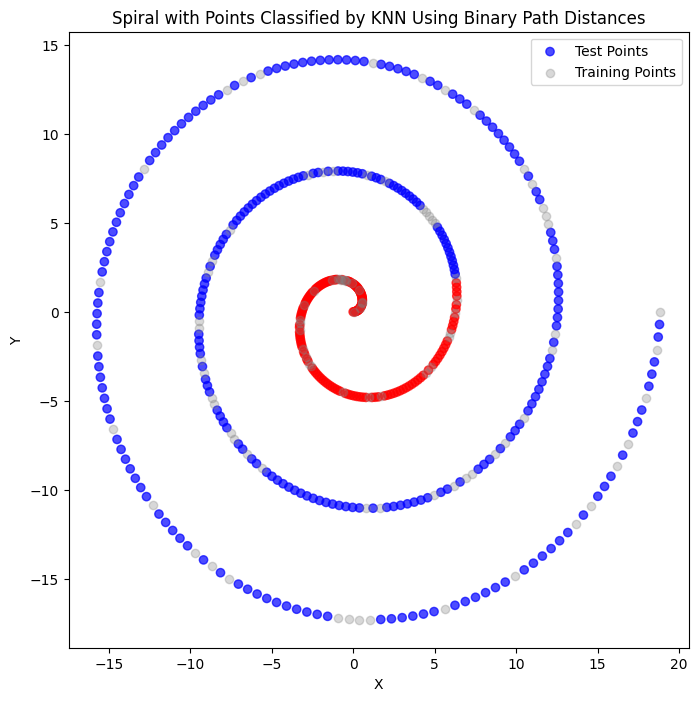

In [6]:
train_idx, test_idx = train_test_split(np.arange(num_points), test_size=test_size, random_state=42)

def rte_distances_for_train(points, train_idx, n_estimators=10):
    train_points = points[train_idx]
    random_trees = RandomTreesEmbedding(n_estimators=n_estimators, random_state=42)
    encoded_points = random_trees.fit_transform(train_points).toarray()

    binary_paths = []
    for estimator in random_trees.estimators_:
        leaf_indices = estimator.apply(points).ravel()
        for leaf_index in leaf_indices:
            binary_path = trace_binary_path(estimator.tree_, leaf_index)
            binary_paths.append(binary_path)

    binary_paths = np.array(binary_paths).reshape(len(random_trees.estimators_), len(points)).T
    print(f'paths shape: {binary_paths.shape}')

    print_tree(random_trees.estimators_[5].tree_)

    num_points = len(points)
    pairwise_distances = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(i + 1, num_points):
            avg_distance = 0
            for k in range(len(random_trees.estimators_)):
                # print(i, j, k)
                try:
                    avg_distance += dist(binary_paths[i][k], binary_paths[j][k])
                except IndexError as ie:
                    print(ie, binary_paths[i][k], binary_paths[j][k])
                    children(random_trees.estimators_[k].tree_)
                    print(
                        random_trees.estimators_[k].apply([points[i], points[j]]),
                    )
                    raise IndexError(ie)
            avg_distance /= len(random_trees.estimators_)
            pairwise_distances[i, j] = avg_distance
            pairwise_distances[j, i] = avg_distance
    return pairwise_distances

train_points = points[train_idx]

print(f'total train points: {len(train_points)}')
random_trees = RandomTreesEmbedding(n_estimators=N_ESTIMATORS, random_state=42)
encoded_points = random_trees.fit_transform(train_points).toarray()

binary_paths = []
for estimator in random_trees.estimators_:
    leaf_indices = estimator.apply(points).ravel()
    for leaf_index in leaf_indices:
        binary_path = trace_binary_path(estimator.tree_, leaf_index)
        binary_paths.append(binary_path)

binary_paths = np.array(binary_paths).reshape(len(random_trees.estimators_), len(points)).T
print(f'paths shape: {binary_paths.shape}')

print_tree(random_trees.estimators_[5].tree_)

num_points = len(points)
pairwise_small = np.zeros((num_points, num_points))
for i in range(num_points):
    for j in range(i + 1, num_points):
        avg_distance = 0
        for k in range(len(random_trees.estimators_)):
            # print(i, j, k)
            try:
                avg_distance += dist(binary_paths[i][k], binary_paths[j][k])
            except IndexError as ie:
                print(ie, binary_paths[i][k], binary_paths[j][k])
                children(random_trees.estimators_[k].tree_)
                print(
                    random_trees.estimators_[k].apply([points[i], points[j]]),
                )
                raise IndexError(ie)
        avg_distance /= len(random_trees.estimators_)
        pairwise_small[i, j] = avg_distance
        pairwise_small[j, i] = avg_distance

D = pairwise_small[:, train_idx]
train_distances = D[train_idx] 
test_distances = D[test_idx] 
train_labels = labels[train_idx]
test_labels = labels[test_idx]

knn = KNeighborsClassifier(n_neighbors=num_neighbors, metric='precomputed')
knn.fit(train_distances, train_labels)

print('KNN Score: ', knn.score(test_distances, test_labels))

predicted_labels = knn.predict(test_distances)

accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Classification Accuracy: {accuracy:.2f}")

plt.figure(figsize=(8, 8))
colors = ['red' if label == 'A' else 'blue' for label in predicted_labels]
plt.scatter(x[test_idx], y[test_idx], c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")
plt.scatter(x[train_idx], y[train_idx], c='gray', alpha=0.3, label="Training Points")
plt.title("Spiral with Points Classified by KNN Using Binary Path Distances")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

In [7]:
import numpy as np
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

# Generate two spirals: one for label A and one for label B (rotated by pi)
def generate_spirals(num_points=500):
    t = np.linspace(0, 6 * np.pi, num_points)
    x_a = t * np.cos(t)
    y_a = t * np.sin(t)
    x_b = t * np.cos(t + np.pi)  # Rotate by pi
    y_b = t * np.sin(t + np.pi)
    points_a = np.vstack((x_a, y_a)).T
    points_b = np.vstack((x_b, y_b)).T
    labels_a = ['A'] * len(points_a)
    labels_b = ['B'] * len(points_b)
    return np.vstack((points_a, points_b)), np.hstack((labels_a, labels_b))



# Generate the data
points, labels = generate_spirals()

# Use Random Trees Embedding to encode the points
N_ESTIMATORS = 10
random_trees = RandomTreesEmbedding(n_estimators=N_ESTIMATORS, random_state=42)
encoded_points = random_trees.fit_transform(points).toarray()

# Compute binary paths for all points
binary_paths = []
for estimator in random_trees.estimators_:
    leaf_indices = estimator.apply(points).ravel()
    for leaf_index in leaf_indices:
        binary_path = trace_binary_path(estimator.tree_, leaf_index)
        binary_paths.append(binary_path)
binary_paths = np.array(binary_paths).reshape(len(random_trees.estimators_), len(points)).T

# Compute pairwise distances based on binary paths
num_points = len(points)
pairwise_distances = np.zeros((num_points, num_points))
for i in range(num_points):
    for j in range(i + 1, num_points):
        avg_distance = 0
        for k in range(len(random_trees.estimators_)):
            avg_distance += dist(binary_paths[i][k], binary_paths[j][k])
        avg_distance /= len(random_trees.estimators_)
        pairwise_distances[i, j] = avg_distance
        pairwise_distances[j, i] = avg_distance


KNN Score:  0.63875
Classification Accuracy: 0.64


C:\Users\Максим\AppData\Local\Temp\ipykernel_38948\3946653457.py:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(points[test_idx, 0], points[test_idx, 1], c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


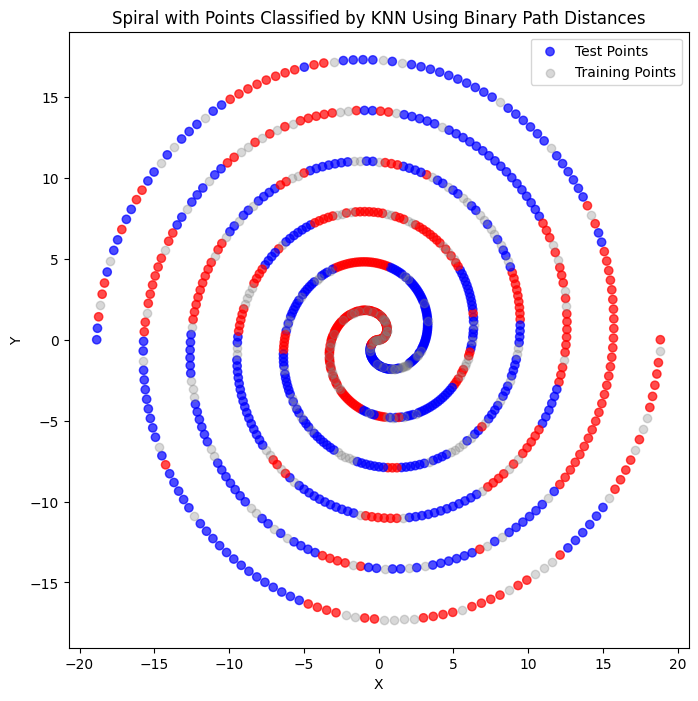

In [8]:
test_size = 0.8
num_neighbors = 5
train_idx, test_idx = train_test_split(np.arange(num_points), test_size=test_size, random_state=42)

D = pairwise_distances[:, train_idx]
train_distances = D[train_idx]
test_distances = D[test_idx]

train_labels = labels[train_idx]
test_labels = labels[test_idx]

knn = KNeighborsClassifier(n_neighbors=num_neighbors, metric='precomputed')
knn.fit(train_distances, train_labels)

print('KNN Score: ', knn.score(test_distances, test_labels))
predicted_labels = knn.predict(test_distances)
accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Classification Accuracy: {accuracy:.2f}")

# other_options(points, labels)

plt.figure(figsize=(8, 8))
colors = ['red' if label == 'A' else 'blue' for label in predicted_labels]
plt.scatter(points[test_idx, 0], points[test_idx, 1], c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")
plt.scatter(points[train_idx, 0], points[train_idx, 1], c='gray', alpha=0.3, label="Training Points")
plt.title("Spiral with Points Classified by KNN Using Binary Path Distances")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

total train points: 200
KNN Score:  0.6425
Classification Accuracy: 0.64


C:\Users\Максим\AppData\Local\Temp\ipykernel_38948\3294489247.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(points[test_idx, 0], points[test_idx, 1], c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


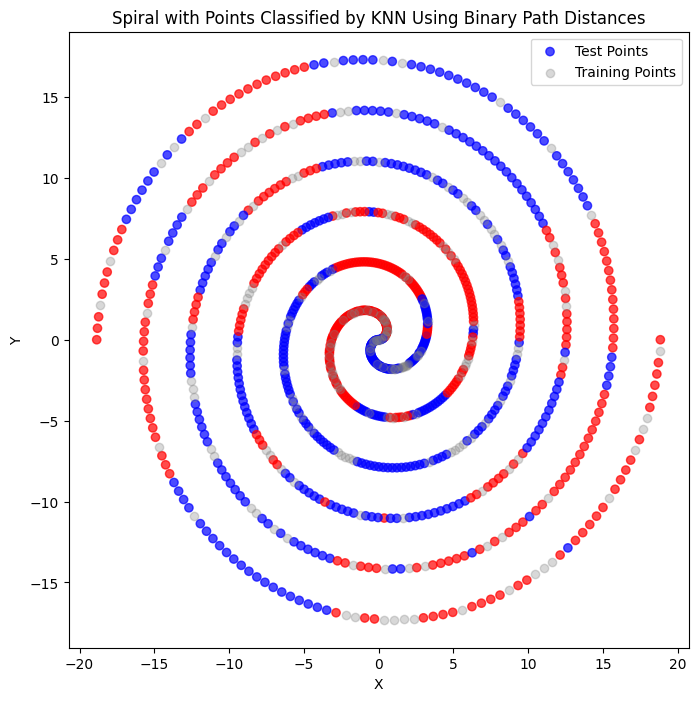

In [9]:
test_size = 0.8
num_neighbors = 5
train_idx, test_idx = train_test_split(np.arange(num_points), test_size=test_size, random_state=42)

train_points = points[train_idx]
print(f'total train points: {len(train_points)}')

random_trees = RandomTreesEmbedding(n_estimators=N_ESTIMATORS, random_state=42)
encoded_points = random_trees.fit_transform(train_points).toarray()

# Compute binary paths for all points
binary_paths = []
for estimator in random_trees.estimators_:
    leaf_indices = estimator.apply(points).ravel()
    for leaf_index in leaf_indices:
        binary_path = trace_binary_path(estimator.tree_, leaf_index)
        binary_paths.append(binary_path)
binary_paths = np.array(binary_paths).reshape(len(random_trees.estimators_), len(points)).T

# Compute pairwise distances based on binary paths
num_points = len(points)
pairwise_distances = np.zeros((num_points, num_points))
for i in range(num_points):
    for j in range(i + 1, num_points):
        avg_distance = 0
        for k in range(len(random_trees.estimators_)):
            avg_distance += dist(binary_paths[i][k], binary_paths[j][k])
        avg_distance /= len(random_trees.estimators_)
        pairwise_distances[i, j] = avg_distance
        pairwise_distances[j, i] = avg_distance

D = pairwise_distances[:, train_idx]
train_distances = D[train_idx]
test_distances = D[test_idx]

train_labels = labels[train_idx]
test_labels = labels[test_idx]

knn = KNeighborsClassifier(n_neighbors=num_neighbors, metric='precomputed')
knn.fit(train_distances, train_labels)

print('KNN Score: ', knn.score(test_distances, test_labels))
predicted_labels = knn.predict(test_distances)
accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Classification Accuracy: {accuracy:.2f}")

plt.figure(figsize=(8, 8))
colors = ['red' if label == 'A' else 'blue' for label in predicted_labels]
plt.scatter(points[test_idx, 0], points[test_idx, 1], c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")
plt.scatter(points[train_idx, 0], points[train_idx, 1], c='gray', alpha=0.3, label="Training Points")
plt.title("Spiral with Points Classified by KNN Using Binary Path Distances")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

## Зашумленные данные

KNN Score:  0.6475
Classification Accuracy: 0.65
Extra Trees Accuracy: 0.7525


c:\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [02:24:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Максим\AppData\Local\Temp\ipykernel_38948\2317741587.py:52: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_test, y_test, c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


XGBoost Accuracy: 0.7288
KNN Accuracy: 0.7013
SVM Accuracy: 0.4938
Extra Trees Accuracy: 0.7525


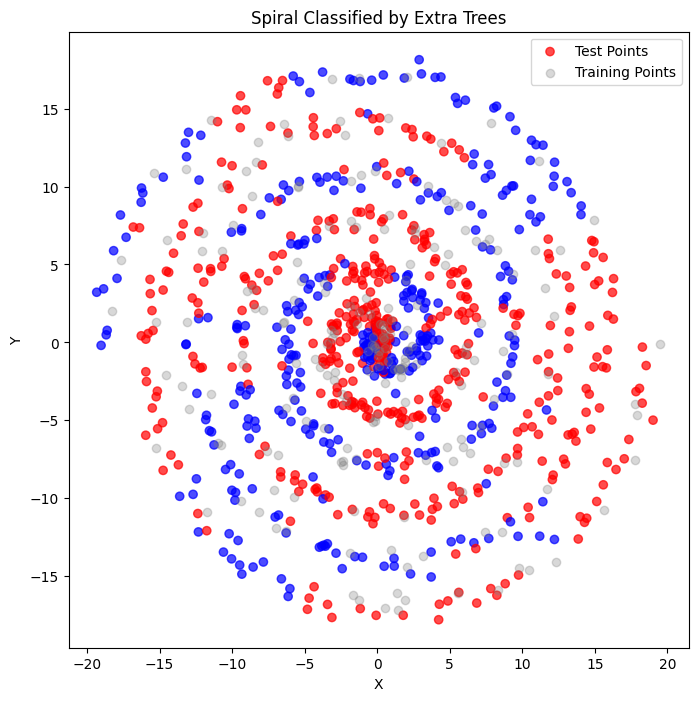

c:\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [02:24:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Максим\AppData\Local\Temp\ipykernel_38948\2317741587.py:52: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_test, y_test, c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


XGBoost Accuracy: 0.7288


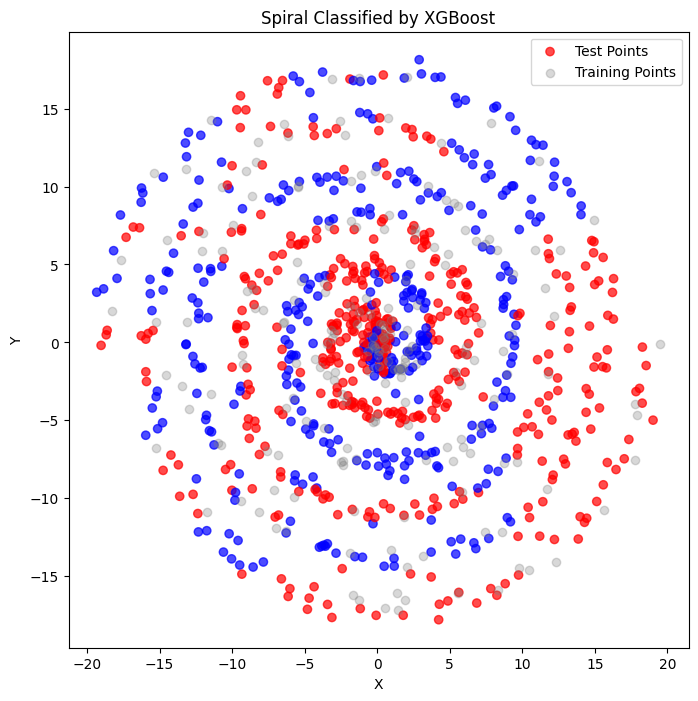

KNN Accuracy: 0.7013


C:\Users\Максим\AppData\Local\Temp\ipykernel_38948\2317741587.py:52: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_test, y_test, c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


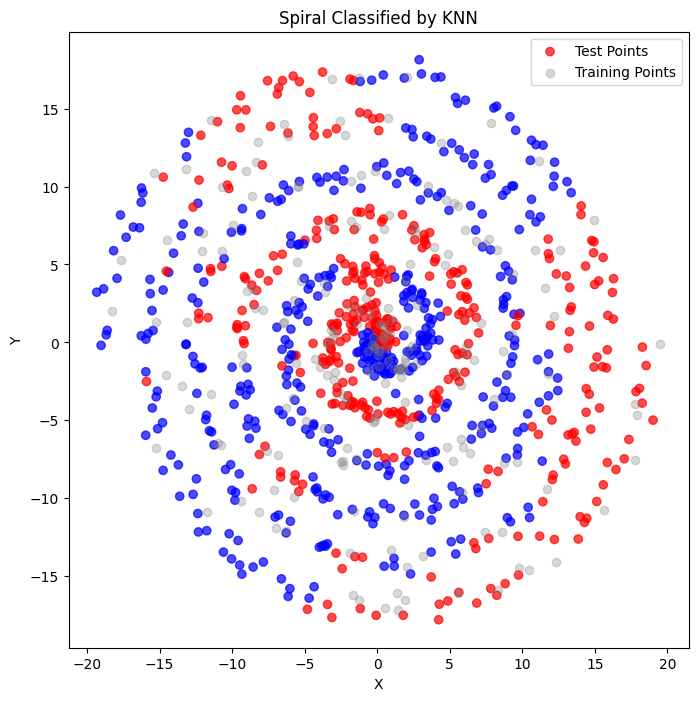

SVM Accuracy: 0.4938


C:\Users\Максим\AppData\Local\Temp\ipykernel_38948\2317741587.py:52: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_test, y_test, c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


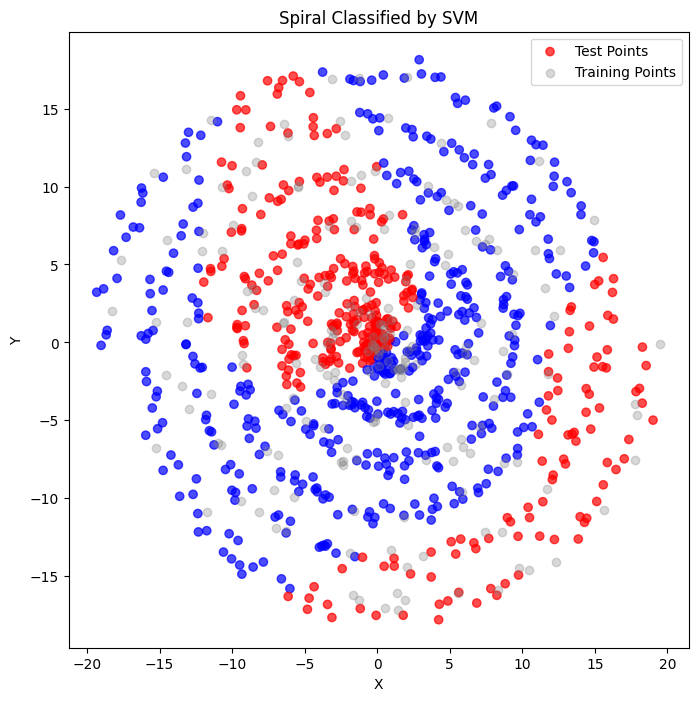

C:\Users\Максим\AppData\Local\Temp\ipykernel_38948\394100523.py:73: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(points[test_idx, 0], points[test_idx, 1], c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


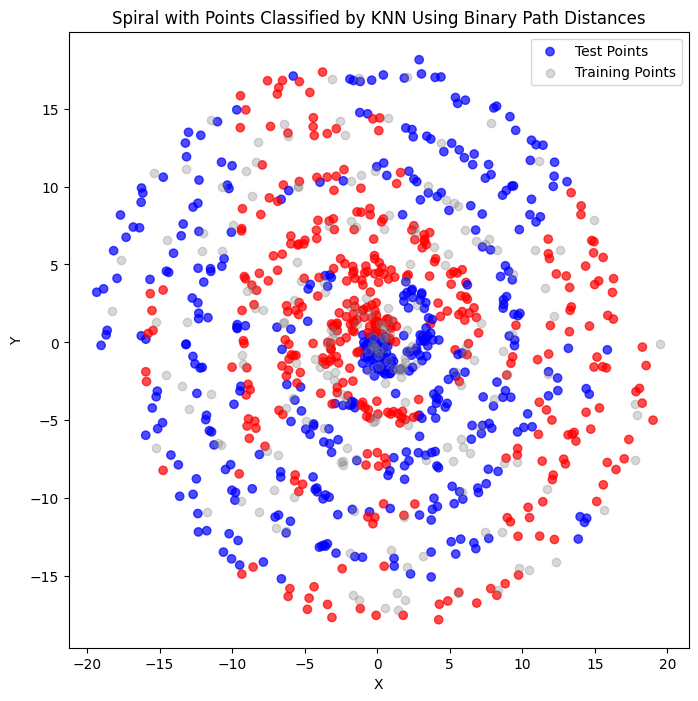

In [10]:
def generate_spirals(num_points=500):
    t = np.linspace(0, 6 * np.pi, num_points)
    std_dev = 0.5
    x_a = t * np.cos(t)
    y_a = t * np.sin(t)
    noise_x_a = np.random.normal(loc=0, scale=std_dev, size=x_a.shape)
    noise_y_a = np.random.normal(loc=0, scale=std_dev, size=y_a.shape)
    x_a = x_a + noise_x_a
    y_a = y_a + noise_y_a
    
    x_b = t * np.cos(t + np.pi)  
    y_b = t * np.sin(t + np.pi)
    noise_x_b = np.random.normal(loc=0, scale=std_dev, size=x_a.shape)
    noise_y_b = np.random.normal(loc=0, scale=std_dev, size=y_a.shape)
    x_b = x_b + noise_x_b
    y_b = y_b + noise_y_b
    points_a = np.vstack((x_a, y_a)).T
    points_b = np.vstack((x_b, y_b)).T
    labels_a = ['A'] * len(points_a)
    labels_b = ['B'] * len(points_b)
    return np.vstack((points_a, points_b)), np.hstack((labels_a, labels_b))



points, labels = generate_spirals()

N_ESTIMATORS = 10
random_trees = RandomTreesEmbedding(n_estimators=N_ESTIMATORS, random_state=42)
encoded_points = random_trees.fit_transform(points).toarray()

binary_paths = []
for estimator in random_trees.estimators_:
    leaf_indices = estimator.apply(points).ravel()
    for leaf_index in leaf_indices:
        binary_path = trace_binary_path(estimator.tree_, leaf_index)
        binary_paths.append(binary_path)
binary_paths = np.array(binary_paths).reshape(len(random_trees.estimators_), len(points)).T

num_points = len(points)
pairwise_distances = np.zeros((num_points, num_points))
for i in range(num_points):
    for j in range(i + 1, num_points):
        avg_distance = 0
        for k in range(len(random_trees.estimators_)):
            avg_distance += dist(binary_paths[i][k], binary_paths[j][k])
        avg_distance /= len(random_trees.estimators_)
        pairwise_distances[i, j] = avg_distance
        pairwise_distances[j, i] = avg_distance

test_size = 0.8
num_neighbors = 5
train_idx, test_idx = train_test_split(np.arange(num_points), test_size=test_size, random_state=42)

D = pairwise_distances[:, train_idx]
train_distances = D[train_idx]
test_distances = D[test_idx]

train_labels = labels[train_idx]
test_labels = labels[test_idx]

knn = KNeighborsClassifier(n_neighbors=num_neighbors, metric='precomputed')
knn.fit(train_distances, train_labels)

print('KNN Score: ', knn.score(test_distances, test_labels))
predicted_labels = knn.predict(test_distances)
accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Classification Accuracy: {accuracy:.2f}")

other_options(points, labels)

plt.figure(figsize=(8, 8))
colors = ['red' if label == 'A' else 'blue' for label in predicted_labels]
plt.scatter(points[test_idx, 0], points[test_idx, 1], c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")
plt.scatter(points[train_idx, 0], points[train_idx, 1], c='gray', alpha=0.3, label="Training Points")
plt.title("Spiral with Points Classified by KNN Using Binary Path Distances")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

In [11]:
def generate_spirals(num_points=500):
    t = np.linspace(0, 6 * np.pi, num_points)
    std_dev = 0.5
    x_a = t * np.cos(t)
    y_a = t * np.sin(t)
    noise_x_a = np.random.normal(loc=0, scale=std_dev, size=x_a.shape)
    noise_y_a = np.random.normal(loc=0, scale=std_dev, size=y_a.shape)
    x_a = x_a + noise_x_a
    y_a = y_a + noise_y_a
    
    x_b = t * np.cos(t + np.pi)  
    y_b = t * np.sin(t + np.pi)
    noise_x_b = np.random.normal(loc=0, scale=std_dev, size=x_a.shape)
    noise_y_b = np.random.normal(loc=0, scale=std_dev, size=y_a.shape)
    x_b = x_b + noise_x_b
    y_b = y_b + noise_y_b
    points_a = np.vstack((x_a, y_a)).T
    points_b = np.vstack((x_b, y_b)).T
    labels_a = ['A'] * len(points_a)
    labels_b = ['B'] * len(points_b)
    return np.vstack((points_a, points_b)), np.hstack((labels_a, labels_b))


# train_idx, test_idx = train_test_split(np.arange(num_points), test_size=test_size, random_state=42)

# test_size = 0.8
# num_neighbors = int(np.round(np.sqrt(len(train_idx))))
# num_neighbors = 5
# print(f'num neighbors: {num_neighbors}')

# points, labels = generate_spirals()
# print(f'total points: {len(points)}')
# train_points = points[train_idx]
# print(f'Total train points: {len(train_points)}')

# random_trees = RandomTreesEmbedding(n_estimators=N_ESTIMATORS, random_state=42)
# encoded_points = random_trees.fit_transform(train_points).toarray()

# binary_paths = []
# for estimator in random_trees.estimators_:
#     leaf_indices = estimator.apply(points).ravel()
#     for leaf_index in leaf_indices:
#         binary_path = trace_binary_path(estimator.tree_, leaf_index)
#         binary_paths.append(binary_path)
# binary_paths = np.array(binary_paths).reshape(len(random_trees.estimators_), len(points)).T

# num_points = len(points)
# pairwise_distances = np.zeros((num_points, num_points))
# for i in range(num_points):
#     for j in range(i + 1, num_points):
#         avg_distance = 0
#         for k in range(len(random_trees.estimators_)):
#             avg_distance += dist(binary_paths[i][k], binary_paths[j][k])
#         avg_distance /= len(random_trees.estimators_)
#         pairwise_distances[i, j] = avg_distance
#         pairwise_distances[j, i] = avg_distance

# D = pairwise_distances[:, train_idx]
# train_distances = D[train_idx]
# test_distances = D[test_idx]

# train_labels = labels[train_idx]
# test_labels = labels[test_idx]

# knn = KNeighborsClassifier(n_neighbors=num_neighbors, metric='precomputed')
# knn.fit(train_distances, train_labels)

# print('KNN Score: ', knn.score(test_distances, test_labels))
# predicted_labels = knn.predict(test_distances)
# accuracy = accuracy_score(test_labels, predicted_labels)
# print(f"Classification Accuracy: {accuracy:.2f}")

# plt.figure(figsize=(8, 8))
# colors = ['red' if label == 'A' else 'blue' for label in predicted_labels]
# plt.scatter(points[test_idx, 0], points[test_idx, 1], c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")
# plt.scatter(points[train_idx, 0], points[train_idx, 1], c='gray', alpha=0.3, label="Training Points")
# plt.title("Spiral with Points Classified by KNN Using Binary Path Distances")
# plt.xlabel("X")
# plt.ylabel("Y")
# plt.legend()
# plt.show()

## Многомерные примеры

a shape: (2,)


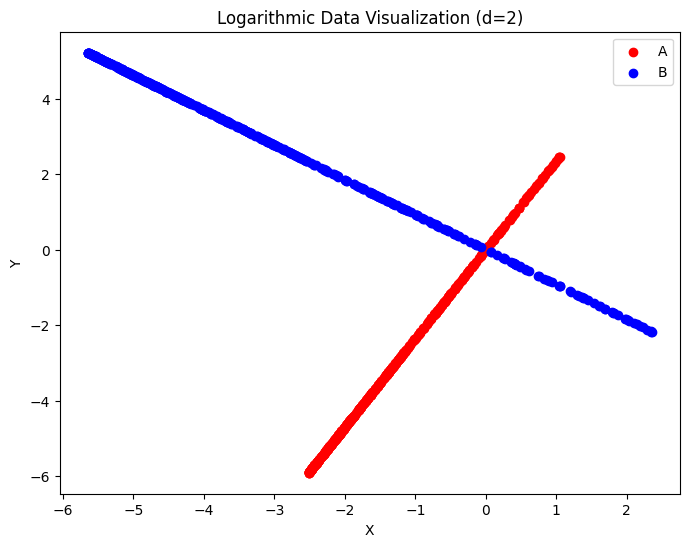

In [12]:
import numpy as np
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt


def dim_spirals(n, d, std_dev=0):
    t = np.linspace(0, 4 * np.pi, n)
    
    x = []
    for i in range(2, d + 1, 2):
        if std_dev != 0:
            cos_noise = np.random.normal(0, std_dev, n)
            sin_noise = np.random.normal(0, std_dev, n)
            x.append(t * np.cos(t * i / 2) + cos_noise)
            x.append(t * np.sin(t * i / 2) + sin_noise)
        else:
            x.append(t * np.cos(t * i / 2))
            x.append(t * np.sin(t * i / 2))
    x = np.array(x).T
    # print(f'x shape: {x.shape}')
    labels_x = ['A'] * n
    
    y = []
    for i in range(2, d + 1, 2):
        if std_dev != 0:
            cos_noise = np.random.normal(0, std_dev, n)
            sin_noise = np.random.normal(0, std_dev, n)
            y.append(t * np.cos(t * i / 2 + np.pi) + cos_noise)
            y.append(t * np.sin(t * i / 2 + np.pi) + sin_noise)
        else:
            y.append(t * np.cos(t * i / 2 + np.pi))
            y.append(t * np.sin(t * i / 2 + np.pi))
    y = np.array(y).T
    labels_y = ['B'] * n
    
    points = np.vstack((x, y))
    labels = labels_x + labels_y
    
    # if d == 2:
    #     plt.figure(figsize=(8, 6))
    #     plt.scatter(points[:n, 0], points[:n, 1], c='red', label='A')
    #     plt.scatter(points[n:, 0], points[n:, 1], c='blue', label='B')
    #     plt.title("Spiral Data Visualization (d=2)")
    #     plt.xlabel("X")
    #     plt.ylabel("Y")
    #     plt.legend()
    #     plt.show()
    
    return points, labels


def dim_logs_uniforms(d):
    a = []
    for _ in range(d):
        flip = np.random.randint(0, 2)
        if flip % 2 == 0:
            a.append(np.random.uniform(-4, -1))
        else:
            a.append(np.random.uniform(1, 4))
    a = np.array(a)
    return a


def dim_logs(n, d):
    t = np.random.uniform(0.5, 5, n)
    a = dim_logs_uniforms(d)
    print(f'a shape: {a.shape}')
    x = np.array([a_i * np.log(t) for a_i in a]).T
    labels_x = ['A'] * n
    
    b = dim_logs_uniforms(d)
    y = np.array([b_i * np.log(t) for b_i in b]).T
    labels_y = ['B'] * n
    
    points = np.vstack((x, y))
    labels = labels_x + labels_y
    
    if d == 2:
        plt.figure(figsize=(8, 6))
        plt.scatter(points[:n, 0], points[:n, 1], c='red', label='A')
        plt.scatter(points[n:, 0], points[n:, 1], c='blue', label='B')
        plt.title("Logarithmic Data Visualization (d=2)")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.legend()
        plt.show()
    
    return points, labels

N = 500
DIM = 2
points, labels = dim_spirals(N, DIM)
points, labels = dim_logs(N, DIM)

### Вспомогательные функции

In [13]:
def rte_distances(points, n_estimators=10):
    random_trees = RandomTreesEmbedding(n_estimators=n_estimators, random_state=42)
    encoded_points = random_trees.fit_transform(points).toarray()

    binary_paths = []
    for estimator in random_trees.estimators_:
        leaf_indices = estimator.apply(points).ravel()
        for leaf_index in leaf_indices:
            binary_path = trace_binary_path(estimator.tree_, leaf_index)
            binary_paths.append(binary_path)

    binary_paths = np.array(binary_paths).reshape(len(random_trees.estimators_), len(points)).T
    print(f'paths shape: {binary_paths.shape}')

    num_points = len(points)
    pairwise_distances = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(i + 1, num_points):
            avg_distance = 0
            for k in range(len(random_trees.estimators_)):
                # print(i, j, k)
                try:
                    avg_distance += dist(binary_paths[i][k], binary_paths[j][k])
                except IndexError as ie:
                    print(ie, binary_paths[i][k], binary_paths[j][k])
                    children(random_trees.estimators_[k].tree_)
                    print(
                        random_trees.estimators_[k].apply([points[i], points[j]]),
                    )
                    raise IndexError(ie)
            avg_distance /= len(random_trees.estimators_)
            pairwise_distances[i, j] = avg_distance
            pairwise_distances[j, i] = avg_distance
    return pairwise_distances


def test_rte(points, labels, pairwise_distances, test_size=0.8, num_neighbors=5):
    # num_neighbors = 5
    num_points = len(points)
    print(f'num points: {num_points}')
    train_idx, test_idx = train_test_split(np.arange(num_points), test_size=test_size, random_state=42)
    # print(f'train idx: {train_idx}')
    D = pairwise_distances[:, train_idx]
    train_distances = D[train_idx] 
    test_distances = D[test_idx] 
    train_labels = labels[train_idx]
    test_labels = labels[test_idx]

    knn = KNeighborsClassifier(n_neighbors=num_neighbors, metric='precomputed')
    knn.fit(train_distances, train_labels)

    print('KNN Score: ', knn.score(test_distances, test_labels))

    predicted_labels = knn.predict(test_distances)

    accuracy = accuracy_score(test_labels, predicted_labels)
    print(f"Classification Accuracy: {accuracy:.2f}")


def rte_distances_for_train(points, train_idx, n_estimators=10):
    train_points = points[train_idx]
    random_trees = RandomTreesEmbedding(n_estimators=n_estimators, random_state=42)
    encoded_points = random_trees.fit_transform(train_points).toarray()

    binary_paths = []
    for estimator in random_trees.estimators_:
        leaf_indices = estimator.apply(points).ravel()
        for leaf_index in leaf_indices:
            binary_path = trace_binary_path(estimator.tree_, leaf_index)
            binary_paths.append(binary_path)

    binary_paths = np.array(binary_paths).reshape(len(random_trees.estimators_), len(points)).T
    print(f'paths shape: {binary_paths.shape}')

    num_points = len(points)
    pairwise_distances = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(i + 1, num_points):
            avg_distance = 0
            for k in range(len(random_trees.estimators_)):
                # print(i, j, k)
                try:
                    avg_distance += dist(binary_paths[i][k], binary_paths[j][k])
                except IndexError as ie:
                    print(ie, binary_paths[i][k], binary_paths[j][k])
                    children(random_trees.estimators_[k].tree_)
                    print(
                        random_trees.estimators_[k].apply([points[i], points[j]]),
                    )
                    raise IndexError(ie)
            avg_distance /= len(random_trees.estimators_)
            pairwise_distances[i, j] = avg_distance
            pairwise_distances[j, i] = avg_distance
    return pairwise_distances


def test_rte_train(points, labels, test_size=0.8, n_estimators=10, num_neighbors=5):
    # num_neighbors = 5
    num_points = len(points)

    train_idx, test_idx = train_test_split(np.arange(num_points), test_size=test_size, random_state=42)
    pairwise_distances = rte_distances_for_train(points, train_idx, n_estimators)
    D = pairwise_distances[:, train_idx]
    train_distances = D[train_idx] 
    test_distances = D[test_idx] 
    train_labels = labels[train_idx]
    test_labels = labels[test_idx]

    knn = KNeighborsClassifier(n_neighbors=num_neighbors, metric='precomputed')
    knn.fit(train_distances, train_labels)

    print('KNN Score: ', knn.score(test_distances, test_labels))

    predicted_labels = knn.predict(test_distances)

    accuracy = accuracy_score(test_labels, predicted_labels)
    print(f"Classification Accuracy: {accuracy:.2f}")


#### Спирали

In [14]:
# N = 500
# DIM = 8
# N_ESTIMATORS = 10
# points, labels = dim_spirals(N, DIM)
# labels = np.array(labels)
# pairwise_distances = rte_distances(points, N_ESTIMATORS)

In [15]:
# print(points.shape)
# print(labels.shape)
# print(pairwise_distances.shape)

In [16]:
# test_rte(points, labels, pairwise_distances)
# other_options(points, labels)

#### Логарифмы

In [17]:
# N = 500
# DIM = 8
# N_ESTIMATORS = 10
# points, labels = dim_logs(N, DIM)
# labels = np.array(labels)
# # print(points.shape)
# # print(labels.shape)
# pairwise_distances = rte_distances(points, N_ESTIMATORS)

In [18]:
# test_rte(points, labels, pairwise_distances)
# other_options(points, labels)

#### Степенные функции

In [19]:
def dim_powers(n, d):
    t = np.random.uniform(0, 5, n)
    x = np.zeros((n, d))
    for i in range(n):
        for j in range(d):
            exponent = (j + 1) / np.sqrt(d)
            x[i, j] = t[i] ** exponent
            
            # Check if the condition 0.8 < (j+1)/sqrt(d) < 1.6 is met
            if 0.8 < exponent < 1.6:
                x[i, j] = np.random.normal(0, 1)  # Replace with Gaussian N(0, 1)
    
    # Generate labels
    labels = np.where(t < 2.5, 'A', 'B')
    
    return x, labels

### Многомерные данные с шумом

In [20]:
# N = 500
# DIM = 8
# N_ESTIMATORS = 10
# points, labels = dim_spirals(N, DIM, 0.5)
# labels = np.array(labels)
# pairwise_distances = rte_distances(points, N_ESTIMATORS)

In [21]:
# test_rte(points, labels, pairwise_distances)
# other_options(points, labels)

### ExtraTreesClassifier как база

#### Проверка формулы через ExtraTrees 

In [22]:
from sklearn.ensemble import ExtraTreesClassifier


def plane_points(n: int, std_dev = 0):
    t = np.linspace(0, 6 * np.pi, n)
    x_a = t * np.cos(t)
    y_a = t * np.sin(t)
    x_b = t * np.cos(t + np.pi)
    y_b = t * np.sin(t + np.pi)
    if std_dev != 0:
        x_a = x_a + np.random.normal(0, std_dev, n)
        y_a = y_a + np.random.normal(0, std_dev, n)
        x_b = x_b + np.random.normal(0, std_dev, n)
        y_b = y_b + np.random.normal(0, std_dev, n)
    points_a = np.vstack((x_a, y_a)).T
    points_b = np.vstack((x_b, y_b)).T
    labels_a = ['A'] * len(points_a)
    labels_b = ['B'] * len(points_b)
    return np.vstack((points_a, points_b)), np.hstack((labels_a, labels_b))


def distances_ET(points, labels, train_idx, n_estimators=10):
    train_points = points[train_idx]
    train_labels = labels[train_idx]
    extrees = ExtraTreesClassifier(n_estimators=n_estimators, random_state=42)
    extrees.fit(train_points, train_labels)

    binary_paths = []
    for estimator in extrees.estimators_:
        leaf_indices = estimator.apply(points).ravel()
        for leaf_index in leaf_indices:
            binary_path = trace_binary_path(estimator.tree_, leaf_index)
            binary_paths.append(binary_path)

    binary_paths = np.array(binary_paths).reshape(len(extrees.estimators_), len(points)).T
    print(f'paths shape: {binary_paths.shape}')

    num_points = len(points)
    pairwise_distances = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(i + 1, num_points):
            avg_distance = 0
            for k in range(len(extrees.estimators_)):
                # print(i, j, k)
                try:
                    avg_distance += dist(binary_paths[i][k], binary_paths[j][k])
                except IndexError as ie:
                    print(ie, binary_paths[i][k], binary_paths[j][k])
                    children(extrees.estimators_[k].tree_)
                    print(
                        extrees.estimators_[k].apply([points[i], points[j]]),
                    )
                    raise IndexError(ie)
            avg_distance /= len(extrees.estimators_)
            pairwise_distances[i, j] = avg_distance
            pairwise_distances[j, i] = avg_distance
    return pairwise_distances


def compared_methods(points, labels, test_size = 0.8, et_estimators: int = 10, num_neighbors = 10, visualize = True):
    X = points
    label_encoder = LabelEncoder()
    trans_labels = label_encoder.fit_transform(labels)
    train_idx, test_idx = train_test_split(np.arange(len(points)), test_size=test_size, random_state=42)
    # print(train_idx, test_idx)
    X_train = X[train_idx]
    X_test = X[test_idx]
    y_train = trans_labels[train_idx]
    y_test = trans_labels[test_idx]
    # X_train, X_test, y_train, y_test = train_test_split(X, trans_labels, test_size=test_size, random_state=42)

    classifiers = {
        "Extra Trees": ExtraTreesClassifier(n_estimators=et_estimators, random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "KNN": KNeighborsClassifier(n_neighbors=num_neighbors),
        "SVM": SVC(kernel='rbf', random_state=42)
    }

    results = {}
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = accuracy
        print(f"{name} Accuracy: {accuracy:.4f}")
    results = {}
    if visualize:
        for name, clf in classifiers.items():
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            predicted_labels = label_encoder.inverse_transform(y_pred)
            accuracy = accuracy_score(y_test, y_pred)
            results[name] = accuracy
            print(f"{name} Accuracy: {accuracy:.4f}")
            if visualize:
                visualize_results(X_train, X_test, y_train, y_test, predicted_labels, title=f"Spiral Classified by {name}")


def test_ET(points, labels, test_size=0.8, n_estimators=10, num_neighbors=5):
    num_points = len(points)

    train_idx, test_idx = train_test_split(np.arange(num_points), test_size=test_size, random_state=42)
    # print(train_idx, test_idx)
    train_labels = labels[train_idx]
    test_labels = labels[test_idx]
    pairwise_distances = distances_ET(points, labels, train_idx, n_estimators)
    D = pairwise_distances[:, train_idx]
    train_distances = D[train_idx] 
    test_distances = D[test_idx]

    knn = KNeighborsClassifier(n_neighbors=num_neighbors, metric='precomputed')
    knn.fit(train_distances, train_labels)

    predicted_labels = knn.predict(test_distances)

    accuracy = accuracy_score(test_labels, predicted_labels)
    print(f"Classification Accuracy: {accuracy:.4f}")

In [23]:
def test_dist_ET():
    n = 20
    n_estimators = 10
    points, labels = plane_points(n)
    a_point = np.random.randint(0, len(points))
    b_point = np.random.randint(0, len(points))
    extrees = ExtraTreesClassifier(n_estimators=n_estimators, random_state=42)
    extrees.fit(points, labels)
    k = np.random.randint(0, n_estimators)
    # a_point, b_point, k = 146, 883, 1
    
    
    print(f'first point: {a_point}, second point: {b_point}, tree: {k}')
    print('Tree structure:')
    actual_estimator = extrees.estimators_[k]
    print_tree(actual_estimator.tree_)
    leaf_a, leaf_b = actual_estimator.apply([points[a_point], points[b_point]])
    print('Leaves:')
    print(leaf_a, leaf_b)
    path_a, path_b = trace_binary_path(actual_estimator.tree_, leaf_a), trace_binary_path(actual_estimator.tree_, leaf_b)
    print(f'Binary paths:\n first: {path_a}, second: {path_b}')


# test_dist_ET()

In [24]:
N = 500
N_ESTIMATORS = 100
points, labels = plane_points(N)
print(points.shape)
print(labels.shape)

(1000, 2)
(1000,)


In [25]:
# test_ET(points, labels, n_estimators=N_ESTIMATORS)
# compared_methods(points, labels, et_estimators=N_ESTIMATORS, visualize=False)

In [26]:
# N = 500
# DIM = 8
# N_ESTIMATORS = 25
# test_size = 0.8
# points, labels = dim_spirals(N, DIM, std_dev=0.5)
# labels = np.array(labels)
# print(points.shape)
# print(labels.shape)

# train_idx, test_idx = train_test_split(np.arange(len(points)), test_size=test_size, random_state=42)

# test_ET(points, labels, n_estimators=N_ESTIMATORS, num_neighbors=3)
# compared_methods(points, labels, et_estimators=N_ESTIMATORS, visualize=False)

### Сравнение ExtraTree(1) с dist_ET(KNN=1, ET=1)

paths shape: (1000, 1)
Classification Accuracy: 0.7837
Single ExtraTree accuracy: 0.7837
(800, 2) (800,)


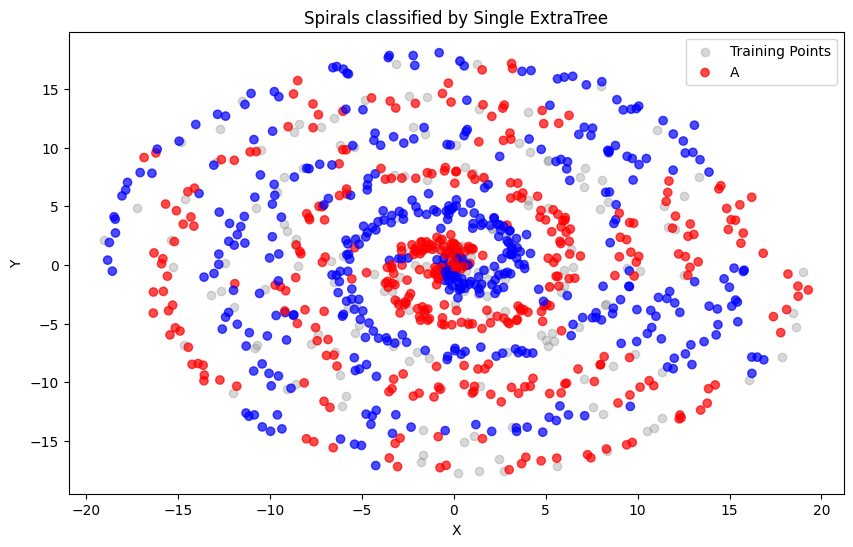

In [27]:
N = 500
test_size = 0.8
points, labels = generate_spirals(N)

def single_et(points, labels, test_size = 0.8, visualize=True):
    X_train, X_test, y_train, y_test = train_test_split(points, labels, test_size=test_size, random_state=42)

    extree = ExtraTreesClassifier(n_estimators=1, random_state=42)
    extree.fit(X_train, y_train)
    y_pred = extree.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Single ExtraTree accuracy: {accuracy:.4f}")
    
    predicted_labels = extree.predict(X_test)
    colors = ['red' if label == 'A' else 'blue' for label in predicted_labels]
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train[:, 0], X_train[:, 1], c='gray', label='Training Points', alpha=0.3)
    print(X_test.shape, y_test.shape)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=colors, label='A', alpha=0.7)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Spirals classified by Single ExtraTree')
    plt.legend()
    plt.show()


test_ET(points, labels, test_size=test_size, n_estimators=1, num_neighbors=1)
single_et(points, labels, test_size=test_size)

#### ExtraTree to Binary path

In [28]:
def et_binary_path(tree, truei, curi, acc):
    left = tree.children_left
    right = tree.children_right
    if left[curi] == -1 and right[curi] == -1:
        if curi == truei:
            acc.append(1)
        else:
            acc.append(0)
        return acc
    acc = et_binary_path(tree, truei, left[curi], acc)
    return et_binary_path(tree, truei, right[curi], acc)

# points, labels = generate_spirals(20)
# rp = np.random.randint(0, len(points))
# X_train, X_test, y_train, y_test = train_test_split(points, labels, test_size=0.8, random_state=42)
# extree = ExtraTreesClassifier(n_estimators=1)
# extree.fit(X_train, y_train)
# print_tree(extree.estimators_[0].tree_)
# print(type(points[rp]))
# leaf = extree.apply([points[rp]])[0][0]
# print(f'Leaf index for {rp}: {leaf}')
# path = et_binary_path(extree.estimators_[0].tree_, leaf, 0, [])
# print(path)

In [29]:
def ET_embedding(extrees: ExtraTreesClassifier, points):
    # print(extrees.apply(points))
    binary_paths = []
    for point in points:
        paths = []
        for est in extrees.estimators_:
            # print(est.apply([point]))
            paths.append(et_binary_path(est.tree_, est.apply([point])[0], 0, []))
        binary_paths.append(np.array([x for sl in paths for x in sl]))
    return binary_paths


def eucl_dist_for_binary_paths(left: np.ndarray, right: np.ndarray):
    return np.sqrt(np.sum(np.not_equal(left, right)))


points, labels = generate_spirals(20)
X_train, X_test, y_train, y_test = train_test_split(points, labels, test_size=0.8, random_state=42)
extrees = ExtraTreesClassifier(n_estimators=5)
extrees.fit(X_train, y_train)


def pairwise_distances_for_ET_paths(points, extrees: ExtraTreesClassifier):
    num_points = len(points)
    distances = np.zeros((num_points, num_points))
    binary_paths = np.array(ET_embedding(extrees, points))
    print(binary_paths.shape)
    print(len(binary_paths))
    for i in range(num_points):
        for j in range(i + 1, num_points):
            # print(i, j)
            # print(len(binary_paths[i]), len(binary_paths[j]))
            eucl_dist_for_binary_paths(binary_paths[i], binary_paths[j])
            distances[i][j] = distances[j][i] = eucl_dist_for_binary_paths(binary_paths[i], binary_paths[j])
    return distances


def test_KNN_by_ET_embedding_dist(points, labels, et_estimators = 5, num_neighbors = 5):
    train_idx, test_idx = train_test_split(np.arange(len(points)), test_size=0.8, random_state=42)
    X_train = points[train_idx]
    X_test = points[test_idx]
    y_train = labels[train_idx]
    y_test = labels[test_idx]
    extrees = ExtraTreesClassifier(n_estimators=et_estimators, random_state=42)
    extrees.fit(X_train, y_train)
    pairwise_distances = pairwise_distances_for_ET_paths(points, extrees)
    D = pairwise_distances[:, train_idx]
    train_distances = D[train_idx] 
    test_distances = D[test_idx]

    knn = KNeighborsClassifier(n_neighbors=num_neighbors, metric='precomputed')
    knn.fit(train_distances, train_labels)
    predicted_labels = knn.predict(test_distances)

    accuracy = accuracy_score(y_test, predicted_labels)
    print(f"ET embedding dist accuracy: {accuracy:.4f}")


def pure_ET_test(points, labels, et_estimators = 5):
    X_train, X_test, y_train, y_test = train_test_split(points, labels, test_size=0.8, random_state=42)
    extrees = ExtraTreesClassifier(n_estimators=et_estimators, random_state=42)
    extrees.fit(X_train, y_train)
    predicted_labels = extrees.predict(X_test)
    accuracy = accuracy_score(y_test, predicted_labels)
    print(f"Pure ExtraTrees accuracy: {accuracy:.4f}")


# print(eucl_dist_for_binary_paths([0, 0, 1, 0, 0, 1, 0], [1, 0, 0, 0, 0, 1, 0]))
# print(ET_embedding(extrees, points))

# N = 500
# N_estimators = 5
# points, labels = generate_spirals(N)
# test_KNN_by_ET_embedding_dist(points, labels, et_estimators=N_estimators)
# test_ET(points, labels, n_estimators=N_estimators)
# pure_ET_test(points, labels, et_estimators=N_estimators)


### Ядерная регрессия и смешивание расстояний

In [30]:
def gaussian_dist_flat(target, other, bandwidth):
    return np.sum((target - other) ** 2) / (2 * bandwidth ** 2)


def mixed_kernel_dist(target_idx, points, labels, train_idx, pairwise_distances, bandwidth=0.5):
    alpha = 0.5
    beta = 1 - alpha
    num_points = len(points)
    weights = []
    for idx in train_idx:
        flat = gaussian_dist_flat(points[target_idx], points[idx], bandwidth)
        weights.append(np.exp(-(alpha * flat + beta * pairwise_distances[target_idx, idx])))
    weights = np.array(weights)
    weights /= np.sum(weights)
    return np.dot(weights, labels[train_idx])


def test_kernel_dist(points, labels, n_estimators=10, bandwidth = 0.5):
    num_points = len(points)
    train_idx, test_idx = train_test_split(np.arange(num_points), test_size=test_size, random_state=42)
    # print(train_idx, test_idx)
    train_labels = labels[train_idx]
    test_labels = labels[test_idx]
    pairwise_distances = distances_ET(points, labels, train_idx, n_estimators)
    D = pairwise_distances[:, train_idx]
    
    y_pred = []
    for single_test in test_idx:
        y_pred.append(
            mixed_kernel_dist(single_test, points, labels, train_idx, pairwise_distances, bandwidth)
        )
    y_pred = np.array(y_pred)
    pred_labels = np.array([0 if pred_v < 0.5 else 1 for pred_v in y_pred])
    accuracy = accuracy_score(test_labels, pred_labels)
    print(f"Kernel Accuracy: {accuracy:.4f}")

#### Получение обученных деревьев

In [31]:
def trained_extra_trees(train_points: np.ndarray, train_labels: np.ndarray, n_estimators: int, random_state: int = 42, max_depth: int | None = None):
    train_points = points[train_idx]
    train_labels = labels[train_idx]
    extrees = ExtraTreesClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state, n_jobs=-1)
    extrees.fit(train_points, train_labels)
    return extrees

#### Предсказания на основе метрики на деревьях

In [32]:
def test_et_predictions(extrees: ExtraTreesClassifier, test_points: np.ndarray, test_labels) -> float:
    pred_labels = extrees.predict(test_points)
    accuracy = accuracy_score(test_labels, pred_labels)
    print(f'ET metric accuracy: {accuracy:.4f}')
    return accuracy

#### Обучение и тестирование произвольной модели

In [33]:
def test_model(data_generator, model_training, model_predictions, model_name: str = '', test_size: float = 0.8, split_state: int = 42):
    points, labels = data_generator()
    train_idx, test_idx = train_test_split(np.arange(len(points)), test_size=test_size, random_state=split_state)
    train_points, test_points = points[train_idx], points[test_idx]
    train_labels, test_labels = labels[train_idx], labels[test_idx]
    model = model_training(train_points, train_labels)
    pred_labels = model_predictions(model, test_points)
    accuracy = accuracy_score(test_labels, pred_labels)
    if model_name != '':
        print(f'{model_name} Accuracy: {accuracy:.4f}')
    return accuracy

#### Переписанная смешанная регрессия

In [34]:
N = 500
DIM = 8
N_ESTIMATORS = 25 # 25, 50...
test_size = 0.8
bandwidth = 1
points, labels = dim_spirals(N, DIM, std_dev=0.5)
labels = np.array(labels)

# train_idx, test_idx = train_test_split(np.arange(len(points)), test_size=test_size, random_state=42)
# test_ET(points, labels, n_estimators=N_ESTIMATORS, num_neighbors=1)

int_labels = np.array([0 if label == 'A' else 1 for label in labels])
# test_kernel_dist(points, int_labels, N_ESTIMATORS, bandwidth)
# compared_methods(points, labels, et_estimators=N_ESTIMATORS, num_neighbors=1, visualize=False)

In [35]:
extrees = ExtraTreesClassifier(n_estimators=10, random_state=42, n_jobs=2)
extrees.fit(points, labels)

ExtraTreesClassifier(n_estimators=10, n_jobs=2, random_state=42)

#### Создание и обучение леса ExtraTrees

In [36]:
def fitted_extrees(train_points: np.ndarray, train_labels: np.ndarray, n_estimators: int, random_state: int = 42, max_depth: int | None = None):
    extrees = ExtraTreesClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state, n_jobs=-1)
    extrees.fit(train_points, train_labels)
    return extrees

#### Быстрое вычисление попарных расстояний

In [37]:
from scipy.spatial.distance import cdist


def trace_binary_path_opt(tree, sample_leaf_index):
    children_left = tree.children_left
    children_right = tree.children_right
    search = sample_leaf_index
    binary_path = []
    while True:
        i = np.where(children_left == search)[0]
        if i.size:
            binary_path.append(0) 
        else:
            i = np.where(children_right == search)[0]
            binary_path.append(1) 
        i = i[0]
        if i == 0:
            break
        search = i
    return np.array(binary_path[::-1], dtype=int)


def dist_diff(x: np.ndarray, y: np.ndarray):
    min_length = min(x.size, y.size)
    diff_idx = np.where(x[:min_length] != y[:min_length])[0]
    if diff_idx.size > 0:
        return max(x.size, y.size) - diff_idx[0]
    return 0


def extrees_pairwise_distances(extrees: ExtraTreesClassifier, points: np.ndarray):
    n_points = points.shape[0]
    n_trees = len(extrees.estimators_)
    def extree_indices(tree):
        return tree.apply(points)
    leaf_indices = np.vectorize(extree_indices)(extrees.estimators_)
    
    pairwise_distances = np.zeros((n_points, n_points))
    
    for t in range(n_trees):
        tree_paths = binary_paths[t] 
        for i in range(n_points):
            for j in range(i + 1, n_points):
                pairwise_distances[i, j] += dist_diff(tree_paths[i], tree_paths[j])
                pairwise_distances[j, i] = pairwise_distances[i, j]
    pairwise_distances /= n_trees
    return pairwise_distances


def extrees_train_pairwise_distances(extrees: ExtraTreesClassifier, points: np.ndarray, train_idx: np.ndarray):
    n_points = points.shape[0]
    n_trees = len(extrees.estimators_)
    leaf_indices = np.array([tree.apply(points) for tree in extrees.estimators_])
    binary_paths = []
    for k in range(n_trees):
        tree = extrees.estimators_[k]
        tree_paths = []
        for pind in range(n_points):
            tree_paths.append(trace_binary_path_opt(tree.tree_, leaf_indices[k, pind]))
        binary_paths.append(tree_paths)
    # binary_paths = np.array(binary_paths)
    n_train_idx = len(train_idx)
    pairwise_distances = np.zeros((n_points, n_train_idx))
    
    for t in range(n_trees):
        tree_paths = binary_paths[t] 
        for j in range(n_train_idx):
            for i in range(n_points):
                pairwise_distances[i, j] += dist(tree_paths[i], tree_paths[train_idx[j]])
    pairwise_distances /= n_trees
    return pairwise_distances

In [38]:
def compare_metric_and_plain_extrees(points: np.ndarray, labels: np.ndarray, n_estimators=10, random_state=42, num_neighbors=5, test_size=0.8, custom_pair_dist = extrees_train_pairwise_distances):
    train_idx, test_idx = train_test_split(np.arange(len(points)), test_size=test_size, random_state=42)
    curt = time.time_ns()
    
    extrees = fitted_extrees(points[train_idx], labels[train_idx], n_estimators, random_state)
    print(f'Fit Time: {(time.time_ns() - curt) / 1_000_000:.5f}')
    curt = time.time_ns()
    
    pairwise_distances = custom_pair_dist(extrees, points, train_idx)
    print(f'Distance calculation Time: {(time.time_ns() - curt) / 1_000_000:.5f}')
    curt = time.time_ns()
    
    D = pairwise_distances
    train_distances = D[train_idx] 
    test_distances = D[test_idx] 
    train_labels = labels[train_idx]
    test_labels = labels[test_idx]
    knn = KNeighborsClassifier(n_neighbors=num_neighbors, metric='precomputed')
    knn.fit(train_distances, train_labels)
    predicted_labels = knn.predict(test_distances)
    accuracy = accuracy_score(test_labels, predicted_labels)
    print(f"Classification Accuracy: {accuracy:.4f}")
    et_predicted = extrees.predict(points[test_idx])
    accuracy = accuracy_score(test_labels, et_predicted)
    print(f"Plain ExtraTrees Accuracy: {accuracy:.4f}")
    print(f'Test Time: {(time.time_ns() - curt) / 1_000_000:.5f}')
    
    knn = KNeighborsClassifier(n_neighbors=num_neighbors)
    knn.fit(points[train_idx], train_labels)
    knn_pred = knn.predict(points[test_idx])
    accuracy = accuracy_score(test_labels, knn_pred)
    print(f'Plain KNN Accuracy: {accuracy:.4f}')


def time_pairdist_implementation(points: np.ndarray, labels: np.ndarray, n_estimators=10, random_state=42, num_neighbors=5, test_size=0.8, custom_pair_dist = extrees_train_pairwise_distances, times = 10, label = ''):
    train_idx, test_idx = train_test_split(np.arange(len(points)), test_size=test_size, random_state=42)
    curt = time.time_ns()
    
    extrees = fitted_extrees(points[train_idx], labels[train_idx], n_estimators, random_state)
    print(f'Fit Time: {(time.time_ns() - curt) / 1_000_000:.5f}')
    curt = time.time_ns()
    for _ in range(times):
        pairwise_distances = custom_pair_dist(extrees, points, train_idx)
    avg_time = (time.time_ns() - curt) / times
    print(f'{label} Average Distance Calculation Time: {avg_time / 1_000_000:.5f}')

In [39]:
import time

N = 500
DIM = 8
N_ESTIMATORS = 10 # 25, 50...
test_size = 0.9
bandwidth = 1
n_estimators = 10
seed = time.time_ns() % (2 ** 32)
print(f'Seed: {seed}')
np.random.seed(seed)
random_state = seed
num_neighbors = 1
test_size = 0.8
points, labels = dim_spirals(N, DIM, std_dev=0.5)
labels = np.array(labels)
train_idx, test_idx = train_test_split(np.arange(len(points)), test_size=test_size, random_state=42)
compare_metric_and_plain_extrees(points, labels, N_ESTIMATORS, random_state, num_neighbors, test_size)


Seed: 1845527064
Fit Time: 121.07020
Distance calculation Time: 4399.18730
Classification Accuracy: 0.9463
Plain ExtraTrees Accuracy: 0.9000
Test Time: 142.35540
Plain KNN Accuracy: 0.9775


#### Дописывание нулей и cdist

In [40]:
from scipy.spatial.distance import cdist


def padded_dist(x: np.ndarray, y: np.ndarray):
    diff_idx = np.where(x != y)[0]
    if diff_idx.size > 0:
        return len(x) - diff_idx[0]
    return 0


def extrees_train_and_cdist_pairwise_dists(extrees: ExtraTreesClassifier, points: np.ndarray, train_idx: np.ndarray):
    n_points = points.shape[0]
    n_trees = len(extrees.estimators_)
    n_train_idx = len(train_idx)
    leaf_indices = np.array([tree.apply(points) for tree in extrees.estimators_])  # Shape: (n_trees, n_points)

    def pad_binary_paths(tree_paths):
        max_length = max(len(path) for path in tree_paths)
        return np.array([np.pad(path, (0, max_length - len(path)), 'constant') for path in tree_paths])
    padded_binary_paths = [
        pad_binary_paths([trace_binary_path_opt(tree.tree_, leaf_indices[k, pind]) for pind in range(n_points)])
        for k, tree in enumerate(extrees.estimators_)
    ]
    pairwise_distances = np.zeros((n_points, n_train_idx))
    for t in range(n_trees):
        tree_paths = padded_binary_paths[t]
        ts = time.time_ns()
        dist_matrix = cdist(tree_paths, tree_paths[train_idx], metric=padded_dist)
        # print(f'cdist time: {(time.time_ns() - ts) / 1_000_000:.4f}')
        pairwise_distances += dist_matrix
    pairwise_distances /= n_trees
    return pairwise_distances

In [41]:
N = 500
DIM = 8
N_ESTIMATORS = 10 # 25, 50...
test_size = 0.9
bandwidth = 1
n_estimators = 10
seed = time.time_ns() % (2 ** 32)
print(f'Seed: {seed}')
np.random.seed(seed)
random_state = seed
num_neighbors = 1
test_size = 0.8
points, labels = dim_spirals(N, DIM, std_dev=0.5)
labels = np.array(labels)
train_idx, test_idx = train_test_split(np.arange(len(points)), test_size=test_size, random_state=42)
compare_metric_and_plain_extrees(points, labels, N_ESTIMATORS, random_state, num_neighbors, test_size, extrees_train_and_cdist_pairwise_dists)

Seed: 2779332468
Fit Time: 81.63800
Distance calculation Time: 9841.81070
Classification Accuracy: 0.9413
Plain ExtraTrees Accuracy: 0.9337
Test Time: 67.94770
Plain KNN Accuracy: 0.9775


#### Сравнение невыравненных путей и cdist 

In [42]:
# N = 500
# DIM = 8
# N_ESTIMATORS = 10 # 25, 50...
# test_size = 0.9
# bandwidth = 1
# n_estimators = 10
# seed = time.time_ns() % (2 ** 32)
# print(f'Seed: {seed}')
# np.random.seed(seed)
# random_state = seed
# num_neighbors = 1
# test_size = 0.8
# points, labels = dim_spirals(N, DIM, std_dev=0.5)
# labels = np.array(labels)
# train_idx, test_idx = train_test_split(np.arange(len(points)), test_size=test_size, random_state=42)

# time_pairdist_implementation(points, labels, N_ESTIMATORS, random_state, num_neighbors, test_size, extrees_train_pairwise_distances, 20, 'Unpadded')
# time_pairdist_implementation(points, labels, N_ESTIMATORS, random_state, num_neighbors, test_size, extrees_train_and_cdist_pairwise_dists, 20, 'Padded')

In [43]:
# N = 500
# DIM = 8
# N_ESTIMATORS = 10 # 25, 50...
# test_size = 0.9
# bandwidth = 1
# n_estimators = 10
# seed = 3249049916
# print(f'Seed: {seed}')
# np.random.seed(seed)
# random_state = seed
# num_neighbors = 1
# test_size = 0.8
# points, labels = dim_spirals(N, DIM, std_dev=0.5)
# labels = np.array(labels)
# train_idx, test_idx = train_test_split(np.arange(len(points)), test_size=test_size, random_state=42)

# time_pairdist_implementation(points, labels, N_ESTIMATORS, random_state, num_neighbors, test_size, extrees_train_pairwise_distances, 10, 'Unpadded')
# time_pairdist_implementation(points, labels, N_ESTIMATORS, random_state, num_neighbors, test_size, extrees_train_and_cdist_pairwise_dists, 10, 'Padded')

In [136]:
def gaussian_dist_flat_bc(points_target, points_other):
    # print(f'{points_target.shape = }, {points_target = }')
    diff = points_target[:, None, :] - points_other[None, :, :]
    # Shape: (n_target_points, n_other_points, n_features)
    return np.sum(diff ** 2, axis=-1)
    # Shape: (n_target_points, n_other_points)


def mixed_kernel_dist_predictions(target_indices, points, labels, train_idx, pairwise_distances, bandwidth=0.5, alpha=0.5):
    beta = 1 - alpha
    points_target = points[target_indices]
    points_train = points[train_idx]
    pairwise_dists_subset = pairwise_distances[target_indices]
    flat_dists = gaussian_dist_flat_bc(points_target, points_train)
    combined_dists = alpha * flat_dists + beta * pairwise_dists_subset
    weights = np.exp(-(combined_dists / (2 * bandwidth ** 2)))
    weights /= np.sum(weights, axis=1, keepdims=True)
    train_labels = labels[train_idx]
    predictions = np.dot(weights, train_labels)
    return predictions


def predictions_from_flat_and_pairdist_mix(target_indices, train_idx, labels, flat_dists, pair_dists, bandwidth, alpha):
    beta = 1 - alpha
    pairwise_dists_subset = pair_dists[target_indices]
    combined_dists = alpha * flat_dists + beta * pairwise_dists_subset
    weights = np.exp(-(combined_dists / (2 * bandwidth ** 2)))
    weights /= np.sum(weights, axis=1, keepdims=True)
    train_labels = labels[train_idx]
    predictions = np.dot(weights, train_labels)
    return predictions


def compare_metric_mix_plain_et_knn(n_estimators=10, num_neighbors=1, test_size=0.8, times = 10, N = 500, DIM = 8, bandwidth=1):
    seeds = []
    metric_res = []
    mix_res = []
    et_res = []
    knn_res = []
    for iter_i in range(times):
        print(f'iter = {iter_i}')
        seed = time.time_ns() % (2 ** 32)
        seeds.append(seed)
        np.random.seed(seed)
        random_state = seed
        points, labels = dim_spirals(N, DIM, std_dev=0.5)
        labels = np.array(labels)
        train_idx, test_idx = train_test_split(np.arange(len(points)), test_size=test_size, random_state=42)
        extrees = fitted_extrees(points[train_idx], labels[train_idx], n_estimators, random_state)
        pair_dists = extrees_train_and_cdist_pairwise_dists(extrees, points, train_idx)
        train_distances = pair_dists[train_idx]
        test_distances = pair_dists[test_idx]
        train_labels = labels[train_idx]
        test_labels = labels[test_idx]
        
        knn = KNeighborsClassifier(n_neighbors=num_neighbors, metric='precomputed')
        knn.fit(train_distances, train_labels)
        predicted_labels = knn.predict(test_distances)
        accuracy = accuracy_score(test_labels, predicted_labels)
        metric_res.append(accuracy)
        
        int_labels = np.array([0 if label == 'A' else 1 for label in labels])
        int_test_labels = int_labels[test_idx]
        mix_pred = mixed_kernel_dist_predictions(test_idx, points, int_labels, train_idx, pair_dists, bandwidth)
        pred_labels = (mix_pred >= 0.5).astype(int)
        accuracy = accuracy_score(int_test_labels, pred_labels)
        mix_res.append(accuracy)
        
        et_predicted = extrees.predict(points[test_idx])
        accuracy = accuracy_score(test_labels, et_predicted)
        et_res.append(accuracy)

        knn = KNeighborsClassifier(n_neighbors=num_neighbors)
        knn.fit(points[train_idx], train_labels)
        knn_pred = knn.predict(points[test_idx])
        accuracy = accuracy_score(test_labels, knn_pred)
        knn_res.append(accuracy)
    return np.array(seeds), np.array(metric_res), np.array(mix_res), np.array(et_res), np.array(knn_res)

In [45]:
seeds, metric_res, mix_res, et_res, knn_res = compare_metric_mix_plain_et_knn(times=10)
print(f'Metric avg: {np.average(metric_res)}')
print(f'Kernel mix avg: {np.average(mix_res)}')
print(f'ExtraTrees avg: {np.average(et_res)}')
print(f'KNN avg: {np.average(knn_res)}')

iter = 0
points_target.shape = (800, 8), points_target = array([[-5.38625503e-01, -6.92716807e-01, -5.92867119e-01, ...,
        -2.39356258e-01,  8.91841079e-01, -5.73342654e-02],
       [-6.75595329e+00,  1.08589243e+00, -4.98638889e+00, ...,
         4.77251039e+00, -8.94799342e-01,  4.80151221e+00],
       [-6.25668025e+00,  1.82008354e+00, -5.77901257e+00, ...,
         3.67486911e+00, -3.87298956e+00,  4.86676342e+00],
       ...,
       [-1.98113903e+00, -7.21460888e+00,  8.25923985e+00, ...,
         5.59491053e+00, -5.14359011e+00,  5.45730781e+00],
       [ 3.33682939e+00,  1.60545209e+00, -1.61134958e+00, ...,
         3.64901353e+00,  1.49581247e+00, -3.65743999e+00],
       [ 6.35188629e+00, -5.86536674e+00,  4.81214095e-03, ...,
        -7.55770284e+00,  8.28272501e+00,  2.10905524e+00]])
iter = 1
points_target.shape = (800, 8), points_target = array([[-0.53019886, -0.97812411, -0.79432686, ..., -0.84166012,
         1.46532147, -1.02025472],
       [-5.39321523,  1.09503

In [46]:
import pandas as pd


accuracies = pd.DataFrame(
    {
        'Seed': seeds,
        'Metric': metric_res,
        'KernelMix': mix_res,
        'ExtraTrees': et_res,
        'KNN': knn_res
    }
)
print(accuracies.head())
accuracies.to_csv('accuracies.csv')

         Seed   Metric  KernelMix  ExtraTrees      KNN
0   681048880  0.93750    0.97625     0.87125  0.96375
1  1758802388  0.92250    0.96500     0.91125  0.97000
2   992463796  0.95375    0.96250     0.89750  0.96250
3   946663404  0.94500    0.97375     0.93625  0.96875
4   103799912  0.96250    0.97750     0.94625  0.97875


In [47]:
print(accuracies.mean())

Seed          1.416146e+09
Metric        9.383750e-01
KernelMix     9.715000e-01
ExtraTrees    9.058750e-01
KNN           9.687500e-01
dtype: float64


In [48]:
def test_mix_alpha_values(n_estimators=10, bandwidth=0.5, test_size=0.8, times=10, N=500, DIM=8):
    alphas = np.arange(0, 1.1, 0.1)
    results = {alpha: np.zeros(times) for alpha in alphas}
    seeds = []
    for it_i in range(times):
        print(f'iter = {it_i}')
        seed = time.time_ns() % (2 ** 32)
        seeds.append(seed)
        np.random.seed(seed)
        random_state = seed
        points, labels = dim_spirals(N, DIM, std_dev=1)
        labels = np.array(labels)
        int_labels = np.array([0 if label == 'A' else 1 for label in labels])
        train_idx, test_idx = train_test_split(np.arange(len(points)), test_size=test_size, random_state=random_state)
        extrees = fitted_extrees(points[train_idx], labels[train_idx], n_estimators, random_state)
        pair_dists = extrees_train_and_cdist_pairwise_dists(extrees, points, train_idx)
        train_labels = labels[train_idx]
        test_labels = int_labels[test_idx]
        flat_dists = gaussian_dist_flat(points[test_idx], points[train_idx])
        for alpha_ in results:
            mix_pred = predictions_from_flat_and_pairdist_mix(test_idx, train_idx, int_labels, flat_dists, pair_dists, bandwidth, alpha_)
            pred_labels = (mix_pred >= 0.5).astype(int)
            results[alpha_][it_i] = accuracy_score(test_labels, pred_labels)
    return seeds, results

In [49]:
# times = 30
# test_size = 0.9
# n_estimators = 20
# seeds, results = test_mix_alpha_values(n_estimators=n_estimators, test_size=test_size, times=times)

In [50]:
# alphas = pd.DataFrame(results)
# alphas['Seed'] = seeds
# print(alphas.head())
# alphas.to_csv(f'alphas_t{times}_ts{test_size}_est{n_estimators}_{time.time_ns()}.csv')

In [51]:
# means = alphas.mean().drop('Seed')
# # print(means)
# plt.plot(means)

In [52]:
# print(means.idxmax())

In [53]:
# print(means)

#### Замеры для ExtraTreesEmbedding

1. Сравнить результаты с ExtraTreesEmbedding
2. Проверить на реальных данных
3. Внести шумовые признаки
4. (Выучить масштабирующую функцию - для регрессии)
5. Расширить окно шума

#### Отображение точек в листья с матрицей расстояний между листьями

In [ ]:
from sklearn.tree import ExtraTreeClassifier


def get_leaf_indices(tree):
    children_left = tree.children_left
    children_right = tree.children_right
    return np.array([i for i in range(tree.node_count) if children_left[i] == -1 and children_right[i] == -1])

def pad_binary_paths(tree_paths):
        max_length = max(len(path) for path in tree_paths)
        return np.array([np.pad(path, (0, max_length - len(path)), 'constant') for path in tree_paths])

def unpadded_dist(x: np.ndarray, y: np.ndarray):
    min_len = min(x.size, y.size)
    diff_idx = np.where(x[:min_len] != y[:min_len])[0]
    if diff_idx.size > 0:
        return max(x.size, y.size) - diff_idx[0]
    return 0

def reciprocal_padded_dist(x: np.ndarray, y: np.ndarray):
    diff_idx = np.where(x != y)[0]
    if diff_idx.size > 0:
        return np.float64(1.0) / (1 + diff_idx[0])
    return 0

def leaf_pair_dists(tree: ExtraTreeClassifier):
    leaf_indices = get_leaf_indices(tree.tree_)
    # print(f'First {leaf_indices = }')
    padded_paths = pad_binary_paths([trace_binary_path_opt(tree.tree_, lind) for lind in leaf_indices])
    # print(f'First {padded_paths = }')
    lind_map = {lind: i for i, lind in enumerate(leaf_indices)}
    # print(f'First {lind_map = }')
    return cdist(padded_paths, padded_paths, metric=padded_dist), lind_map

def leaf_no_cdist_pair_dists(tree: ExtraTreeClassifier):
    leaf_indices = get_leaf_indices(tree.tree_)
    # print(f'Second {leaf_indices = }')
    plain_paths = pad_binary_paths([trace_binary_path_opt(tree.tree_, lind) for lind in leaf_indices])
    # print(f'Second {plain_paths = }')
    lind_map = {lind: i for i, lind in enumerate(leaf_indices)}
    # print(f'Second {lind_map = }')
    pair_dists = np.zeros((leaf_indices.size, leaf_indices.size))
    for i in range(leaf_indices.size):
        for j in range(i + 1, leaf_indices.size):
            pair_dists[i, j] = unpadded_dist(plain_paths[i], plain_paths[j])
            pair_dists[j, i] = pair_dists[i, j]
    return pair_dists, lind_map
    # return cdist(plain_paths, plain_paths, metric=padded_dist), lind_map

def padded_no_cdist_leaf_dists(tree: ExtraTreeClassifier):
    leaf_indices = get_leaf_indices(tree.tree_)
    # print(f'Second {leaf_indices = }')
    padded_paths = pad_binary_paths([trace_binary_path_opt(tree.tree_, lind) for lind in leaf_indices])
    n_paths = len(padded_paths)
    # print(f'Second {padded_paths = }')
    lind_map = {lind: i for i, lind in enumerate(leaf_indices)}
    # print(f'Second {lind_map = }')
    pair_dists = np.zeros((n_paths, n_paths))
    # print(f'Second {pair_dists.shape = }, {n_paths = }, {padded_paths.shape = }')
    for i in range(n_paths):
        for j in range(i + 1, n_paths):
            pair_dists[i, j] = padded_dist(padded_paths[i], padded_paths[j])
            pair_dists[j, i] = pair_dists[i, j]
    return pair_dists, lind_map


def padded_reciprocal_leaf_dists(tree: ExtraTreeClassifier):
    leaf_indices = get_leaf_indices(tree.tree_)
    padded_paths = pad_binary_paths([trace_binary_path_opt(tree.tree_, lind) for lind in leaf_indices])
    n_paths = len(padded_paths)
    lind_map = {lind: i for i, lind in enumerate(leaf_indices)}
    pair_dists = np.zeros((n_paths, n_paths))
    for i in range(n_paths):
        for j in range(i + 1, n_paths):
            pair_dists[i, j] = reciprocal_padded_dist(padded_paths[i], padded_paths[j])
            pair_dists[j, i] = pair_dists[i, j]
    return pair_dists, lind_map


def leaf_unpadded_pair_dists(tree: ExtraTreeClassifier):
    leaf_indices = get_leaf_indices(tree.tree_)
    padded_paths = pad_binary_paths([trace_binary_path_opt(tree.tree_, lind) for lind in leaf_indices])
    lind_map = {lind: i for i, lind in enumerate(leaf_indices)}
    return cdist(padded_paths, padded_paths, metric=padded_dist), lind_map

def leaf_precomp_pairwise_distances(extrees: ExtraTreesClassifier, points: np.ndarray, train_idx: np.ndarray):
    n_points = points.shape[0]
    n_trees = len(extrees.estimators_)
    n_train_idx = len(train_idx)
    leaf_indices = np.array([tree.apply(points) for tree in extrees.estimators_])  # Shape: (n_trees, n_points)
    # print(f'First {leaf_indices = }')
    pairwise_distances = np.zeros((n_points, n_train_idx))
    for t in range(n_trees):
        tree = extrees.estimators_[t]
        leaves = leaf_indices[t].reshape(-1, 1)
        # print(f'First {leaves = }')
        leaf_dists, lind_map = leaf_pair_dists(tree)
        # print(f'First {leaf_dists = }')
        def leaf_cache_dist(x: np.ndarray, y: np.ndarray):
            return leaf_dists[lind_map[x[0]], lind_map[y[0]]]
        ts = time.time_ns()
        cdist_temp = cdist(leaves, leaves[train_idx], metric=leaf_cache_dist)
        # print(f'{cdist_temp = }')
        pairwise_distances += cdist_temp
        # print(f'cdist time: {(time.time_ns() - ts) / 1_000_000:.4f}')
    pairwise_distances /= n_trees
    return pairwise_distances

def leaf_precomp_no_cdist_pairwise_distances_with_padded_no_cdist_leaves(extrees: ExtraTreeClassifier, points: np.array, train_idx: np.ndarray):
    n_points = points.shape[0]
    n_trees = len(extrees.estimators_)
    n_train_idx = len(train_idx)
    leaf_indices = np.array([tree.apply(points) for tree in extrees.estimators_])  # Shape: (n_trees, n_points)
    # print(f'Second {leaf_indices = }')
    pairwise_distances = np.zeros((n_points, n_train_idx))
    for t in range(n_trees):
        tree = extrees.estimators_[t]
        leaves = leaf_indices[t]
        leaves_train = leaves[train_idx]
        # print(f'Second {leaves = }')
        leaf_dists, lind_map = padded_no_cdist_leaf_dists(tree)
        # print(f'Second {leaf_dists = }')
        for i in range(n_points):
            for j in range(n_train_idx):
                pairwise_distances[i, j] += leaf_dists[lind_map[leaves[i]], lind_map[leaves_train[j]]]
    # print(f'{pairwise_distances = }')
    pairwise_distances /= n_trees
    return pairwise_distances


def leaf_precomp_no_cdist_pairwise_distances_with_padded_reciprocal_leaves(extrees: ExtraTreeClassifier, points: np.array, train_idx: np.ndarray):
    n_points = points.shape[0]
    n_trees = len(extrees.estimators_)
    n_train_idx = len(train_idx)
    leaf_indices = np.array([tree.apply(points) for tree in extrees.estimators_])  # Shape: (n_trees, n_points)
    # print(f'Second {leaf_indices = }')
    pairwise_distances = np.zeros((n_points, n_train_idx))
    for t in range(n_trees):
        tree = extrees.estimators_[t]
        leaves = leaf_indices[t]
        leaves_train = leaves[train_idx]
        # print(f'Second {leaves = }')
        leaf_dists, lind_map = padded_reciprocal_leaf_dists(tree)
        # print(f'Second {leaf_dists = }')
        for i in range(n_points):
            for j in range(n_train_idx):
                pairwise_distances[i, j] += leaf_dists[lind_map[leaves[i]], lind_map[leaves_train[j]]]
    # print(f'{pairwise_distances = }')
    pairwise_distances /= n_trees
    return pairwise_distances


def leaf_precomp_unpadded_pairwise_distances(extrees: ExtraTreeClassifier, points: np.array, train_idx: np.ndarray):
    n_points = points.shape[0]
    n_trees = len(extrees.estimators_)
    n_train_idx = len(train_idx)
    leaf_indices = np.array([tree.apply(points) for tree in extrees.estimators_])  # Shape: (n_trees, n_points)
    pairwise_distances = np.zeros((n_points, n_train_idx))
    for t in range(n_trees):
        tree = extrees.estimators_[t]
        leaves = leaf_indices[t]
        leaf_dists, lind_map = leaf_pair_dists(tree)
        for i in range(n_points):
            for j in range(n_train_idx):
                pairwise_distances[i, j] += leaf_dists[lind_map[leaves[i]], lind_map[leaves[j]]]
    pairwise_distances /= n_trees
    return pairwise_distances

def leaf_precomp_unpadded_no_cdist_pairwise_distances(extrees: ExtraTreeClassifier, points: np.array, train_idx: np.ndarray):
    n_points = points.shape[0]
    n_trees = len(extrees.estimators_)
    n_train_idx = len(train_idx)
    leaf_indices = np.array([tree.apply(points) for tree in extrees.estimators_])  # Shape: (n_trees, n_points)
    # print(f'Second {leaf_indices = }')
    pairwise_distances = np.zeros((n_points, n_train_idx))
    for t in range(n_trees):
        tree = extrees.estimators_[t]
        leaves = leaf_indices[t]
        leaf_dists, lind_map = leaf_no_cdist_pair_dists(tree)
        # print(f'Second {leaf_dists = }')
        for i in range(n_points):
            for j in range(n_train_idx):
                pairwise_distances[i, j] += leaf_dists[lind_map[leaves[i]], lind_map[leaves[j]]]
    pairwise_distances /= n_trees
    return pairwise_distances

#### Метрика несовпадений

In [137]:
def mismatch_metric(extrees: ExtraTreeClassifier, points: np.array, train_idx: np.ndarray):
    n_points = points.shape[0]
    n_trees = len(extrees.estimators_)
    n_train_idx = len(train_idx)
    leaf_indices = np.array([tree.apply(points) for tree in extrees.estimators_]).T  # Shape: (n_points, n_trees)
    # print(f'Second {leaf_indices = }')
    pairwise_distances = np.zeros((n_points, n_train_idx))
    for i in range(n_points):
        for j, train_i in enumerate(train_idx):
            pairwise_distances[i, j] += 2 * np.sum(leaf_indices[i] != leaf_indices[train_i])
    # print(f'{pairwise_distances = }')
    # pairwise_distances /= n_trees
    return pairwise_distances

##### Сравнение функций подсчета расстояний

In [56]:
points, labels = dim_spirals(5, 2, 0.5)
labels = np.array(labels)
train_idx, test_idx = train_test_split(np.arange(len(points)), test_size=0.5, random_state=42)
print(f'{len(train_idx)}, {len(test_idx)}')
extrees = fitted_extrees(points[train_idx], labels[train_idx], 1)
first_pairs = leaf_precomp_pairwise_distances(extrees, points, train_idx)
second_pairs = leaf_precomp_no_cdist_pairwise_distances_with_padded_no_cdist_leaves(extrees, points, train_idx)
print(first_pairs - second_pairs)

5, 5
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


##### Замеры скорости для отображений в листья через cdist и невыровненные пути

In [57]:
# N = 500
# DIM = 8
# test_size = 0.9
# bandwidth = 1
# n_estimators = 10
# seed = time.time_ns() % (2 ** 32)
# print(f'Seed: {seed}')
# np.random.seed(seed)
# random_state = seed
# num_neighbors = 1
# test_size = 0.8
# points, labels = dim_spirals(N, DIM, std_dev=0.5)
# labels = np.array(labels)
# train_idx, test_idx = train_test_split(np.arange(len(points)), test_size=test_size, random_state=42)

# # time_pairdist_implementation(points, labels, n_estimators, random_state, num_neighbors, test_size, leaf_precomp_pairwise_distances, 10, 'Padded Leaves')
# time_pairdist_implementation(points, labels, n_estimators, random_state, num_neighbors, test_size, leaf_precomp_pairwise_distances, 10, 'Padded Leaves')
# time_pairdist_implementation(points, labels, n_estimators, random_state, num_neighbors, test_size, leaf_precomp_no_cdist_pairwise_distances_with_padded_no_cdist_leaves, 10, 'Padded + No cdist Leaves')

#### Тестирование скорости работы

In [58]:
def leaf_precomp_compare_metric_mix_plain_et_knn(n_estimators=10, num_neighbors=1, test_size=0.8, times = 10, N = 500, DIM = 8, bandwidth=1):
    seeds = []
    metric_res = []
    mix_res = []
    et_res = []
    knn_res = []
    for iter_i in range(times):
        print(f'iter = {iter_i}')
        seed = time.time_ns() % (2 ** 32)
        seeds.append(seed)
        np.random.seed(seed)
        random_state = seed
        points, labels = dim_spirals(N, DIM, std_dev=0.5)
        labels = np.array(labels)
        train_idx, test_idx = train_test_split(np.arange(len(points)), test_size=test_size, random_state=42)
        extrees = fitted_extrees(points[train_idx], labels[train_idx], n_estimators, random_state)
        pair_dists = leaf_precomp_unpadded_no_cdist_pairwise_distances(extrees, points, train_idx)
        train_distances = pair_dists[train_idx]
        test_distances = pair_dists[test_idx]
        train_labels = labels[train_idx]
        test_labels = labels[test_idx]
        
        knn = KNeighborsClassifier(n_neighbors=num_neighbors, metric='precomputed')
        knn.fit(train_distances, train_labels)
        predicted_labels = knn.predict(test_distances)
        accuracy = accuracy_score(test_labels, predicted_labels)
        metric_res.append(accuracy)
        
        int_labels = np.array([0 if label == 'A' else 1 for label in labels])
        int_test_labels = int_labels[test_idx]
        mix_pred = mixed_kernel_dist_predictions(test_idx, points, int_labels, train_idx, pair_dists, bandwidth)
        pred_labels = (mix_pred >= 0.5).astype(int)
        accuracy = accuracy_score(int_test_labels, pred_labels)
        mix_res.append(accuracy)
        
        et_predicted = extrees.predict(points[test_idx])
        accuracy = accuracy_score(test_labels, et_predicted)
        et_res.append(accuracy)

        knn = KNeighborsClassifier(n_neighbors=num_neighbors)
        knn.fit(points[train_idx], train_labels)
        knn_pred = knn.predict(points[test_idx])
        accuracy = accuracy_score(test_labels, knn_pred)
        knn_res.append(accuracy)
    return np.array(seeds), np.array(metric_res), np.array(mix_res), np.array(et_res), np.array(knn_res)

In [59]:
# seeds, metric_res, mix_res, et_res, knn_res = leaf_precomp_compare_metric_mix_plain_et_knn(times=10)
# print(f'Metric avg: {np.average(metric_res)}')
# print(f'Kernel mix avg: {np.average(mix_res)}')
# print(f'ExtraTrees avg: {np.average(et_res)}')
# print(f'KNN avg: {np.average(knn_res)}')

In [60]:
# import pandas as pd

# accuracies = pd.DataFrame(
#     {
#         'Seed': seeds,
#         'Metric': metric_res,
#         'KernelMix': mix_res,
#         'ExtraTrees': et_res,
#         'KNN': knn_res
#     }
# )
# # print(accuracies.head())
# accuracies.to_csv('accuracies.csv')
# print(accuracies.mean())

In [61]:
n = 500
d = 8
n_estimators = 10
test_size = 0.8
points, labels = dim_spirals(n, d, 1.5)
labels = np.array(labels)
train_idx, test_idx = train_test_split(np.arange(len(points)), test_size=test_size, random_state=42)
extrees = fitted_extrees(points[train_idx], labels[train_idx], n_estimators, random_state=42)
res = extrees.apply(points[test_idx])
print(res.shape)

(800, 10)


#### Breast Cancer

In [62]:
import openml
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

dataset_id = 15  #  Breast Cancer (Wisconsin)
dataset = openml.datasets.get_dataset(dataset_id)

X, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="dataframe", target=dataset.default_target_attribute
)

times = 10
test_size = 0.95
random_state_base = 42

results = []

# print(X)

for i in range(times):
    random_state = random_state_base + i
    n_X = len(X)
    train_idx, test_idx = train_test_split(np.arange(n_X), test_size=test_size, random_state=random_state)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    print(len(X_train))
    imputer = SimpleImputer(strategy='mean')
    X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=attribute_names)
    X_test = pd.DataFrame(imputer.transform(X_test), columns=attribute_names)
    
    # scaler = StandardScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)
    
    model = ExtraTreesClassifier(random_state=random_state, n_estimators=10, class_weight='balanced')
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results.append(accuracy)
    
    print(f"Run {i+1}: Accuracy = {accuracy:.4f}")

results = np.array(results)
print("\nSummary of Results:")
print(f"Accuracy scores across runs: {results}")
print(f"Mean accuracy: {np.mean(results):.4f} ± {np.std(results):.4f}")

34
Run 1: Accuracy = 0.9398
34
Run 2: Accuracy = 0.9368
34
Run 3: Accuracy = 0.9519
34
Run 4: Accuracy = 0.9158
34
Run 5: Accuracy = 0.9624
34
Run 6: Accuracy = 0.9684
34
Run 7: Accuracy = 0.9609
34
Run 8: Accuracy = 0.9233
34
Run 9: Accuracy = 0.9519
34
Run 10: Accuracy = 0.9188

Summary of Results:
Accuracy scores across runs: [0.93984962 0.93684211 0.9518797  0.91578947 0.96240602 0.96842105
 0.96090226 0.92330827 0.9518797  0.91879699]
Mean accuracy: 0.9430 ± 0.0181


### Тестирование на реальных данных

In [63]:
def test_on_real_data(data_gen, n_estimators=10, num_neighbors=1, test_size=0.8, times = 10, bandwidth=1):
    seeds = []
    metric_res = []
    mix_res = []
    et_res = []
    knn_res = []
    for iter_i in range(times):
        print(f'iter = {iter_i}')
        seed = time.time_ns() % (2 ** 32)
        seeds.append(seed)
        np.random.seed(seed)
        random_state = seed
        points, labels, train_idx, test_idx = data_gen(test_size, random_state)
        # print(f'points: {type(points), points.shape = }')
        # print(f'train-test intersection: {set(train_idx).intersection(set(test_idx))}')
        # print(f'max idx in train: {np.max(train_idx)}')
        # print(f'max idx in test: {np.max(test_idx)}')
        # print(f'labels: {type(labels)}')
        # # labels = np.array(labels)
        # pti = points[train_idx]
        # lti = labels[train_idx]
        extrees = fitted_extrees(points[train_idx], labels[train_idx], n_estimators, random_state)
        curt = time.time_ns()
        pair_dists = leaf_precomp_no_cdist_pairwise_distances_with_padded_no_cdist_leaves(extrees, points, train_idx)
        print(f'Pairdist time = {(time.time_ns() - curt) / 1_000_000:.4f}')
        train_distances = pair_dists[train_idx]
        test_distances = pair_dists[test_idx]
        train_labels = labels[train_idx]
        test_labels = labels[test_idx]
        
        knn = KNeighborsClassifier(n_neighbors=num_neighbors, metric='precomputed')
        knn.fit(train_distances, train_labels)
        predicted_labels = knn.predict(test_distances)
        accuracy = accuracy_score(test_labels, predicted_labels)
        metric_res.append(accuracy)
        
        # int_labels = np.array([0 if label == 'A' else 1 for label in labels])
        # int_test_labels = int_labels[test_idx]
        # mix_pred = mixed_kernel_dist_predictions(test_idx, points, labels, train_idx, pair_dists, bandwidth)
        # pred_labels = np.round(mix_pred)
        # accuracy = accuracy_score(test_labels, pred_labels)
        # mix_res.append(accuracy)
        
        et_predicted = extrees.predict(points[test_idx])
        accuracy = accuracy_score(test_labels, et_predicted)
        et_res.append(accuracy)

        knn = KNeighborsClassifier(n_neighbors=num_neighbors)
        knn.fit(points[train_idx], train_labels)
        knn_pred = knn.predict(points[test_idx])
        accuracy = accuracy_score(test_labels, knn_pred)
        knn_res.append(accuracy)
    return np.array(seeds), np.array(metric_res), np.array(mix_res), np.array(et_res), np.array(knn_res)

#### Единообразный подсчет метрик

In [64]:
from sklearn.metrics import roc_auc_score, f1_score


def calculate_acc_auroc_f1(label: str, results: dict[str, dict[str, list[float]]], test_labels: np.ndarray, pred_labels: np.ndarray, pred_probs: np.ndarray) -> None:
    binary_classification = len(np.unique(test_labels)) == 2
    results['Accuracy'][label].append(accuracy_score(test_labels, pred_labels))
    
    if binary_classification:
        results['AUROC'][label].append(roc_auc_score(test_labels, pred_probs[:, 1]))
        results['F1'][label].append(f1_score(test_labels, pred_labels, average='binary'))
    else:
        results['AUROC'][label].append(roc_auc_score(test_labels, pred_probs, multi_class='ovr', average='macro'))
        results['F1'][label].append(f1_score(test_labels, pred_labels, average='macro'))
    # results['Accuracy']['Metric'].append(accuracy_score(test_labels, predicted_labels))
    # if binary_classification:
    #     results['AUROC']['Metric'].append(roc_auc_score(test_labels, y_pred_proba[:, 1]))
    #     results['F1']['Metric'].append(f1_score(test_labels, predicted_labels, average='binary'))
    # else:
    #     results['AUROC']['Metric'].append(roc_auc_score(test_labels, y_pred_proba, multi_class='ovr', average='macro'))
    #     results['F1']['Metric'].append(f1_score(test_labels, predicted_labels, average='macro'))

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder


def kernel_mix_transform_labels(labels, train_idx):
    if len(labels.shape) == 1:
        one_hot_encoder = OneHotEncoder(sparse_output=False)
        one_hot_encoder.fit(labels[train_idx].reshape(-1, 1))
        labels_one_hot = one_hot_encoder.transform(labels.reshape(-1, 1))
    else:
        labels_one_hot = labels
    return labels_one_hot


def cross_validate_real_data(data_gen, data_prep, n_estimators=10, num_neighbors=1, bandwidth=1, alpha=0.5, n_splits = 5, n_repeats = 2, test_swap = False):
    seeds = []
    metric_res = []
    mix_res = []
    et_res = []
    knn_res = []
    base_points, base_labels = data_gen()
    print(f'Unique labels: {np.unique(base_labels)}')
    print(f'len(base_points) = {len(base_points)}')
    random_state = 42
    results = {
        'Accuracy': {'Metric': [], 'Mismatch': [],  'Mix0.00': [],  'Mix0.25': [], 'Mix0.50': [], 'Mix0.75': [], 'KR': [], 'ExtraTrees': [], 'KNN': []},
        'AUROC': {'Metric': [], 'Mismatch': [],  'Mix0.00': [],  'Mix0.25': [], 'Mix0.50': [], 'Mix0.75': [], 'KR': [], 'ExtraTrees': [], 'KNN': []},
        'F1': {'Metric': [], 'Mismatch': [],  'Mix0.00': [],  'Mix0.25': [], 'Mix0.50': [], 'Mix0.75': [], 'KR': [], 'ExtraTrees': [], 'KNN': []},
    }
    rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    for fold_idx, (train_idx, test_idx) in enumerate(rskf.split(base_points, base_labels)):
        if test_swap:
            train_idx, test_idx = test_idx, train_idx
        print(f'Fold = {fold_idx + 1}')
        points, labels = data_prep(base_points, base_labels, train_idx)
        train_points, train_labels = points[train_idx], labels[train_idx]
        test_points, test_labels = points[test_idx], labels[test_idx]
        binary_classification = len(np.unique(labels)) == 2
        
        extrees = fitted_extrees(train_points, train_labels, n_estimators, random_state)
        curt = time.time_ns()
        pair_dists = leaf_precomp_no_cdist_pairwise_distances_with_padded_no_cdist_leaves(extrees, points, train_idx)
        print(f'Pairdist time = {(time.time_ns() - curt) / 1_000_000:.4f}')
        train_distances = pair_dists[train_idx]
        test_distances = pair_dists[test_idx]

        knn_precomputed = KNeighborsClassifier(n_neighbors=num_neighbors, metric='precomputed')
        knn_precomputed.fit(train_distances, train_labels)
        predicted_labels = knn_precomputed.predict(test_distances)
        y_pred_proba = knn_precomputed.predict_proba(test_distances)
        calculate_acc_auroc_f1('Metric', results, test_labels, predicted_labels, y_pred_proba)
        
        
        knn_mismatch = KNeighborsClassifier(n_neighbors=num_neighbors, metric='precomputed')
        mismatch_dists = mismatch_metric(extrees, points, train_idx)
        knn_mismatch.fit(mismatch_dists[train_idx], train_labels)
        mismatch_pred = knn_mismatch.predict(mismatch_dists[test_idx])
        mismatch_proba = knn_mismatch.predict_proba(mismatch_dists[test_idx])
        calculate_acc_auroc_f1('Mismatch', results, test_labels, mismatch_pred, mismatch_proba)

        
        mix_labels = kernel_mix_transform_labels(labels, train_idx)
        flat_dists = gaussian_dist_flat_bc(test_points, train_points)
        # mix_pred_proba = mixed_kernel_dist_predictions(test_idx, points, mix_labels, train_idx, pair_dists, bandwidth, alpha=alpha)
        
        
        mix_pred_proba = predictions_from_flat_and_pairdist_mix(test_idx, train_idx, mix_labels, flat_dists, pair_dists, bandwidth, 0.0)
        mix_pred_labels = np.argmax(mix_pred_proba, axis=1)
        calculate_acc_auroc_f1('Mix0.00', results, test_labels, mix_pred_labels, mix_pred_proba)
        
        
        mix_pred_proba = predictions_from_flat_and_pairdist_mix(test_idx, train_idx, mix_labels, flat_dists, pair_dists, bandwidth, 0.25)
        # print(f'{mix_pred_proba = }')
        # mix_test_labels = mix_labels[test_idx]
        # print(f'{mix_test_labels = }')
        
        mix_pred_labels = np.argmax(mix_pred_proba, axis=1)
        # print(f'{mix_pred_labels = }')
        # mix_true_labels = np.argmax(mix_test_labels, axis=1)
        calculate_acc_auroc_f1('Mix0.25', results, test_labels, mix_pred_labels, mix_pred_proba)
        
        
        mix_pred_proba = predictions_from_flat_and_pairdist_mix(test_idx, train_idx, mix_labels, flat_dists, pair_dists, bandwidth, 0.5)
        mix_pred_labels = np.argmax(mix_pred_proba, axis=1)
        calculate_acc_auroc_f1('Mix0.50', results, test_labels, mix_pred_labels, mix_pred_proba)
        
        
        mix_pred_proba = predictions_from_flat_and_pairdist_mix(test_idx, train_idx, mix_labels, flat_dists, pair_dists, bandwidth, 0.75)
        mix_pred_labels = np.argmax(mix_pred_proba, axis=1)
        calculate_acc_auroc_f1('Mix0.75', results, test_labels, mix_pred_labels, mix_pred_proba)
        
        
        kernel_pred_proba = predictions_from_flat_and_pairdist_mix(test_idx, train_idx, mix_labels, flat_dists, pair_dists, bandwidth, 1.0)
        kernel_pred_labels = np.argmax(kernel_pred_proba, axis=1)
        calculate_acc_auroc_f1('KR', results, test_labels, kernel_pred_labels, kernel_pred_proba)

        
        et_predicted = extrees.predict(test_points)
        et_pred_proba = extrees.predict_proba(test_points)
        calculate_acc_auroc_f1('ExtraTrees', results, test_labels, et_predicted, et_pred_proba)


        knn_default = KNeighborsClassifier(n_neighbors=num_neighbors)
        knn_default.fit(train_points, train_labels)
        knn_pred = knn_default.predict(test_points)
        knn_pred_proba = knn_default.predict_proba(test_points)
        # accuracy = accuracy_score(test_labels, knn_pred)
        # knn_res.append(accuracy)
        calculate_acc_auroc_f1('KNN', results, test_labels, knn_pred, knn_pred_proba)
    return results


def old():
    # for iter_i in range(times):


    #     extrees = fitted_extrees(points[train_idx], labels[train_idx], n_estimators, random_state)
    #     pair_dists = leaf_precomp_unpadded_no_cdist_pairwise_distances(extrees, points, train_idx)
    #     train_distances = pair_dists[train_idx]
    #     test_distances = pair_dists[test_idx]
    #     train_labels = labels[train_idx]
    #     test_labels = labels[test_idx]
        
    #     knn = KNeighborsClassifier(n_neighbors=num_neighbors, metric='precomputed')
    #     knn.fit(train_distances, train_labels)
    #     predicted_labels = knn.predict(test_distances)
    #     accuracy = accuracy_score(test_labels, predicted_labels)
    #     metric_res.append(accuracy)
        
    #     # int_labels = np.array([0 if label == 'A' else 1 for label in labels])
    #     # int_test_labels = int_labels[test_idx]
    #     # mix_pred = mixed_kernel_dist_predictions(test_idx, points, labels, train_idx, pair_dists, bandwidth)
    #     # pred_labels = np.round(mix_pred)
    #     # accuracy = accuracy_score(test_labels, pred_labels)
    #     # mix_res.append(accuracy)
        
    #     et_predicted = extrees.predict(points[test_idx])
    #     accuracy = accuracy_score(test_labels, et_predicted)
    #     et_res.append(accuracy)

    #     knn = KNeighborsClassifier(n_neighbors=num_neighbors)
    #     knn.fit(points[train_idx], train_labels)
    #     knn_pred = knn.predict(points[test_idx])
    #     accuracy = accuracy_score(test_labels, knn_pred)
    #     knn_res.append(accuracy)
    # return np.array(seeds), np.array(metric_res), np.array(mix_res), np.array(et_res), np.array(knn_res)
    return 1

In [ ]:
def to_metric_model_dataframe(results: dict[dict[str, float]]):
    metrics = ["Accuracy", "AUROC", "F1"]
    # 'Metric': [],  'Mix0.00': [],  'Mix0.25': [], 'Mix0.50': [], 'Mix0.75': [], 'KR': [], 'ExtraTrees': [], 'KNN': []
    models = ["Metric", "Mismatch", "Mix0.00", "Mix0.25", "Mix0.50", "Mix0.75", "KR", "ExtraTrees", "KNN"]
    columns = pd.MultiIndex.from_product([metrics, models], names=["Metric", "Model"])
    data = {
        (metric, model): results[metric][model]
        for metric in metrics
        for model in models
    }
    return pd.DataFrame(data, columns=columns)

In [144]:
from sklearn.preprocessing import LabelEncoder

def test_mismatch():
    points, labels = dim_spirals(200, 2, 0.5)
    labels = LabelEncoder().fit_transform(labels)
    train_idx, test_idx = train_test_split(np.arange(len(points)), test_size=0.8, random_state=42)
    labels = np.array(labels)
    results = {
        'Accuracy': {'Mismatch': [], 'ExtraTrees': []},
        'AUROC': {'Mismatch': [], 'ExtraTrees': []},
        'F1': {'Mismatch': [], 'ExtraTrees': []},
    }
    train_labels, test_labels = labels[train_idx], labels[test_idx]
    
    extrees = ExtraTreesClassifier(n_estimators=100, random_state=42)
    extrees.fit(points[train_idx], labels[train_idx])
    et_pred = extrees.predict(points[test_idx])
    et_proba =extrees.predict_proba(points[test_idx])
    calculate_acc_auroc_f1('ExtraTrees', results, test_labels, et_pred, et_proba)
    
    mismatch_dists = mismatch_metric(extrees, points, train_idx)
    
    train_distances = mismatch_dists[train_idx]
    test_distances = mismatch_dists[test_idx]

    knn_precomputed = KNeighborsClassifier(n_neighbors=num_neighbors, metric='precomputed')
    knn_precomputed.fit(train_distances, train_labels)
    pred_labels = knn_precomputed.predict(test_distances)
    y_pred_proba = knn_precomputed.predict_proba(test_distances)
    calculate_acc_auroc_f1('Mismatch', results, test_labels, pred_labels, y_pred_proba)
    df = pd.DataFrame(results)
    print(df)

test_mismatch()

              Accuracy                 AUROC                    F1
Mismatch      [0.8375]   [0.838497909421281]  [0.8433734939759037]
ExtraTrees  [0.821875]  [0.8942597006760189]  [0.8308605341246291]


In [100]:
from sklearn.preprocessing import LabelEncoder


def wisconsin_breast_cancer(test_size, random_state: int):
    dataset_id = 15  #  Breast Cancer (Wisconsin)
    dataset = openml.datasets.get_dataset(dataset_id)
    X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="dataframe", target=dataset.default_target_attribute
    )
    train_indices, test_indices = train_test_split(
        np.arange(len(X)), test_size=test_size, stratify=y, random_state=random_state
    )
    
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

    imputer = SimpleImputer(strategy='mean')
    imputer.fit(X_train)

    scaler = StandardScaler()
    X_imputed = imputer.transform(X)
    scaler.fit(imputer.transform(X_train))
    X_scaled = scaler.transform(X_imputed)
    return X_scaled, y, train_indices, test_indices

def dataset_wisconsin_breast_cancer():
    dataset_id = 15  #  Breast Cancer (Wisconsin)
    dataset = openml.datasets.get_dataset(dataset_id)
    X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="dataframe", target=dataset.default_target_attribute
    )
    return X, y

def wisconsin_breast_cancer_prepared(X, y, train_indices: np.ndarray):
    X_train = X.iloc[train_indices]
    imputer = SimpleImputer(strategy='mean')
    imputer.fit(X_train)
    scaler = StandardScaler()
    X_imputed = imputer.transform(X)
    scaler.fit(imputer.transform(X_train))
    X_scaled = scaler.transform(X_imputed)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    return X_scaled, y_encoded

In [101]:
# seeds, metric_res, mix_res, et_res, knn_res = test_on_real_data(
#     wisconsin_breast_cancer,
#     n_estimators=20,
#     test_size=0.99,
#     times=10
# )
# print(f'Metric avg: {np.average(metric_res)}')
# print(f'Kernel mix avg: {np.average(mix_res)}')
# print(f'ExtraTrees avg: {np.average(et_res)}')
# print(f'KNN avg: {np.average(knn_res)}')

n_estimators = 10
num_neighbors = 1
test_swap = True
n_splits = 10
n_repeats = 1
alpha = 0.8
bandwidth = 0.8
results = cross_validate_real_data(
    dataset_wisconsin_breast_cancer,
    wisconsin_breast_cancer_prepared,
    n_estimators=n_estimators,
    num_neighbors=num_neighbors,
    test_swap=test_swap,
    n_splits=n_splits,
    n_repeats=n_repeats,
    alpha=alpha,
    bandwidth=bandwidth
)

Unique labels: ['benign' 'malignant']
len(base_points) = 699
Fold = 1
Pairdist time = 579.2551
points_target.shape = (629, 9), points_target = array([[ 0.18339994, -0.66930295, -0.73527342, ..., -0.27037149,
        -0.57251966, -0.32167709],
       [-0.51054577, -0.66930295, -0.73527342, ..., -0.27037149,
        -0.57251966, -0.32167709],
       [ 0.53037279,  1.97552322,  2.03614177, ..., -0.27037149,
         1.29149784, -0.32167709],
       ...,
       [ 0.18339994,  2.73118784,  2.82797468, ...,  1.88031078,
         2.22350659,  0.38199155],
       [-0.16357292,  1.97552322,  1.24430886, ...,  2.74058369,
         0.98082826, -0.32167709],
       [-0.16357292,  1.97552322,  2.03614177, ...,  2.74058369,
         0.35948909, -0.32167709]])
Fold = 2
Pairdist time = 633.0169
points_target.shape = (629, 9), points_target = array([[ 0.15211987, -0.69664579, -0.72375799, ..., -0.18876839,
        -0.56960316, -0.39034719],
       [ 0.15211987,  0.17416145,  0.18635685, ..., -0.1887683

In [102]:
def csv_name(label: str, n_estimators: int, num_neighbors: int, test_swap: bool, n_splits: int, n_repeats: int, alpha: float, bandwidth: float):
    return f'./data/{label}_{time.time_ns()}_est{n_estimators}_k{num_neighbors}_{"swapped" if test_swap else "unswapped"}_sp{n_splits}_rp{n_repeats}_alpha{alpha}_bw{bandwidth}.csv'

In [103]:
def save_and_print_results(results: dict, label: str):
    results_df = to_metric_model_dataframe(results)
    file_name = csv_name(label, n_estimators, num_neighbors, test_swap, n_splits, n_repeats, alpha, bandwidth)
    results_df.to_csv(file_name, index=False)
    print(f'{label.capitalize()}:')
    print(results_df.mean() * 100)
    return file_name, results_df

In [104]:
import pandas as pd
import time

wisconsin_csv, wisconsin_df = save_and_print_results(results, 'wisconsin')

Wisconsin:
Metric    Model     
Accuracy  Metric        94.928963
          Mix0.00       92.846771
          Mix0.25       94.786206
          Mix0.50       95.390239
          Mix0.75       95.533323
          KR            95.358417
          ExtraTrees    95.612739
          KNN           94.960961
AUROC     Metric        94.034365
          Mix0.00       99.114511
          Mix0.25       99.353803
          Mix0.50       99.332895
          Mix0.75       99.287713
          KR            99.238521
          ExtraTrees    98.696819
          KNN           93.850645
F1        Metric        92.508326
          Mix0.00       88.751589
          Mix0.25       92.117776
          Mix0.50       93.113679
          Mix0.75       93.368574
          KR            93.100119
          ExtraTrees    93.573871
          KNN           92.482396
dtype: float64


#### Diabetic Retinopathy

In [105]:
def stratified_subsample(X, y, sample_size, random_state=42):
    if sample_size == len(X):
        return X, y
    X_sample, _, y_sample, _ = train_test_split(
        X, y, train_size=sample_size, stratify=y, random_state=random_state
    )
    return X_sample, y_sample

In [106]:
def diabetic_retinopathy(test_size=0.2, random_state=42):
    # dataset_id = 40666  # Dataset ID for Diabetic Retinopathy
    dataset_id = 43341
    dataset = openml.datasets.get_dataset(dataset_id)

    X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="dataframe", target=dataset.default_target_attribute
    )
    # print(len(X))
    indices = np.arange(len(X))
    train_indices, test_indices = train_test_split(
        indices, test_size=test_size, stratify=y, random_state=random_state
    )
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

    imputer = SimpleImputer(strategy='mean')
    imputer.fit(X_train)  # Fit only on the training data
    scaler = StandardScaler()
    X_imputed = imputer.transform(X)
    scaler.fit(imputer.transform(X_train))
    X_scaled = scaler.transform(X_imputed)
    return X_scaled, y, train_indices, test_indices

def dataset_diabetic_retinopathy():
    dataset_id = 37  #  43341 40666
    dateset_id = 43759
    dataset = openml.datasets.get_dataset(dataset_id)
    X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="dataframe", target=dataset.default_target_attribute
    )
    return X, y

def diabetic_retinopathy_prepared(X, y, train_indices: np.ndarray):
    X_train = X.iloc[train_indices]
    imputer = SimpleImputer(strategy='mean')
    imputer.fit(X_train)  # Fit only on the training data
    scaler = StandardScaler()
    X_imputed = imputer.transform(X)
    scaler.fit(imputer.transform(X_train))
    X_scaled = scaler.transform(X_imputed)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    return X_scaled, y_encoded

# diabetic_retinopathy()

In [107]:
n_estimators = 10
num_neighbors = 1
test_swap = False
n_splits = 5
n_repeats = 2
alpha = 0.8
bandwidth = 0.8
retinopathy_results = cross_validate_real_data(
    dataset_diabetic_retinopathy,
    diabetic_retinopathy_prepared,
    n_estimators=n_estimators,
    num_neighbors=num_neighbors,
    test_swap=test_swap,
    n_splits=n_splits,
    n_repeats=n_repeats,
    alpha=alpha,
    bandwidth=bandwidth
)

Unique labels: ['tested_negative' 'tested_positive']
len(base_points) = 768
Fold = 1
Pairdist time = 5894.7493
points_target.shape = (154, 8), points_target = array([[-1.15057907e+00,  5.13454476e-01, -1.47141979e+00, ...,
         1.41858224e+00,  6.10401127e+00, -1.82321067e-03],
       [ 3.22430831e-01,  1.42936015e+00,  1.40088350e-01, ...,
        -8.28195501e-01,  4.56649381e-01,  1.54818635e+00],
       [ 1.50083875e+00, -5.50386986e-02,  5.42965385e-01, ...,
        -4.12606554e-01, -6.19038598e-01, -3.46269779e-01],
       ...,
       [-2.66773128e-01, -5.91948919e-01, -1.26998127e+00, ...,
        -1.78837772e-01, -1.64195224e-01, -6.04604706e-01],
       [-8.55977086e-01,  2.29207889e-01,  9.45842420e-01, ...,
         5.61430039e-01,  2.01706096e+00,  3.42623358e-01],
       [ 1.79544073e+00, -6.23531873e-01,  3.41526868e-01, ...,
         9.38924742e-02, -9.24480864e-01,  2.58152605e+00]])
Fold = 2
Pairdist time = 5817.3149
points_target.shape = (154, 8), points_target = a

In [108]:
retinopathy_csv, retinopathy_df = save_and_print_results(retinopathy_results, 'retinopathy')

Retinopathy:
Metric    Model     
Accuracy  Metric        70.634072
          Mix0.00       72.459469
          Mix0.25       73.435617
          Mix0.50       73.955522
          Mix0.75       74.151176
          KR            74.281895
          ExtraTrees    72.851201
          KNN           70.045837
AUROC     Metric        66.971384
          Mix0.00       78.059469
          Mix0.25       78.924458
          Mix0.50       79.681761
          Mix0.75       80.515793
          KR            80.627149
          ExtraTrees    77.761461
          KNN           66.301433
F1        Metric        56.531506
          Mix0.00       52.822560
          Mix0.25       55.238066
          Mix0.50       56.178618
          Mix0.75       56.832251
          KR            57.099356
          ExtraTrees    55.320510
          KNN           55.692485
dtype: float64


In [109]:
print(retinopathy_df.columns)

MultiIndex([('Accuracy',     'Metric'),
            ('Accuracy',    'Mix0.00'),
            ('Accuracy',    'Mix0.25'),
            ('Accuracy',    'Mix0.50'),
            ('Accuracy',    'Mix0.75'),
            ('Accuracy',         'KR'),
            ('Accuracy', 'ExtraTrees'),
            ('Accuracy',        'KNN'),
            (   'AUROC',     'Metric'),
            (   'AUROC',    'Mix0.00'),
            (   'AUROC',    'Mix0.25'),
            (   'AUROC',    'Mix0.50'),
            (   'AUROC',    'Mix0.75'),
            (   'AUROC',         'KR'),
            (   'AUROC', 'ExtraTrees'),
            (   'AUROC',        'KNN'),
            (      'F1',     'Metric'),
            (      'F1',    'Mix0.00'),
            (      'F1',    'Mix0.25'),
            (      'F1',    'Mix0.50'),
            (      'F1',    'Mix0.75'),
            (      'F1',         'KR'),
            (      'F1', 'ExtraTrees'),
            (      'F1',        'KNN')],
           names=['Metric', 'Model'])


#### EEG Eyes

In [110]:
from functools import partial


def prepare_eeg_eyes(test_size=0.2, random_state=42, subsample_size=1.0):
    dataset_id = 1471  # Dataset ID for EEG Eyes
    dataset = openml.datasets.get_dataset(dataset_id)
    X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="dataframe", target=dataset.default_target_attribute
    )
    X, y = stratified_subsample(X, y, int(len(X) * subsample_size), random_state=random_state)
    # print('X len = ', len(X))
    indices = np.arange(len(X))
    train_indices, test_indices = train_test_split(
        indices, test_size=test_size, stratify=y, random_state=random_state
    )
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
    imputer = SimpleImputer(strategy='mean')
    imputer.fit(X_train)
    scaler = StandardScaler()
    X_imputed = imputer.transform(X)
    scaler.fit(imputer.transform(X_train))
    X_scaled = scaler.transform(X_imputed)
    # print(f'Scaled shape: {X_scaled.shape = }')
    return X_scaled, y.to_numpy(), train_indices, test_indices

def dataset_eeg_eyes():
    dataset_id = 1471  # Dataset ID for EEG Eyes
    dataset = openml.datasets.get_dataset(dataset_id)
    X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="dataframe", target=dataset.default_target_attribute
    )
    
    subsample_size = 0.5
    X, y = stratified_subsample(X, y, int(len(X) * subsample_size), random_state=42)
    return X, y

def eeg_eyes_prepared(X, y, train_indices: np.ndarray):
    X_train = X.iloc[train_indices]
    imputer = SimpleImputer(strategy='mean')
    imputer.fit(X_train)  # Fit only on the training data
    scaler = StandardScaler()
    X_imputed = imputer.transform(X)
    scaler.fit(imputer.transform(X_train))
    X_scaled = scaler.transform(X_imputed)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y.to_numpy())
    return X_scaled, y_encoded

# X, _, _, _ = prepare_eeg_eyes_subsampled(subsample_size=0.1)
# print(len(X))
# prepare_eeg_eyes()

In [111]:
n_estimators = 10
num_neighbors = 1
test_swap = True
n_splits = 10
n_repeats = 1
alpha = 0.8
bandwidth = 0.8
eeg_eyes_results = cross_validate_real_data(
    dataset_eeg_eyes,
    eeg_eyes_prepared,
    n_estimators=n_estimators,
    num_neighbors=num_neighbors,
    test_swap=test_swap,
    n_splits=n_splits,
    n_repeats=n_repeats,
    alpha=alpha,
    bandwidth=bandwidth
)

Unique labels: ['1' '2']
len(base_points) = 7490
Fold = 1
Pairdist time = 59092.3049
points_target.shape = (6741, 14), points_target = array([[ 1.38467792, -1.04076523,  0.63559239, ...,  1.3383711 ,
         2.62005449,  2.11230743],
       [-2.29182539, -1.21422467, -1.67134193, ..., -1.6731338 ,
        -1.74921913, -2.10562768],
       [ 1.50213484, -0.38209273,  0.51261331, ...,  0.7795449 ,
         1.49649608,  1.75676809],
       ...,
       [-0.14073663,  0.34623405, -0.19894266, ..., -0.82352855,
        -0.34842254, -0.62202202],
       [-1.23573005, -0.10449   , -0.86168981, ..., -0.89598652,
        -1.38867427, -1.44356417],
       [-1.07937506, -0.39933724, -0.91049863, ..., -0.55595499,
        -0.7922741 , -1.18605518]])
Fold = 2
Pairdist time = 53333.5767
points_target.shape = (6741, 14), points_target = array([[ 1.61929127, -1.07985464,  0.770192  , ...,  1.72062649,
         3.44079835,  2.62935164],
       [-2.48517966, -1.26204067, -1.79906352, ..., -1.91769544,
 

In [112]:
eeg_eyes_csv, eeg_eyes_df = save_and_print_results(eeg_eyes_results, 'eeg_eyes')

Eeg_eyes:
Metric    Model     
Accuracy  Metric        78.725708
          Mix0.00       79.028334
          Mix0.25       79.970331
          Mix0.50       80.483608
          Mix0.75       80.191366
          KR            78.469070
          ExtraTrees    76.936656
          KNN           83.937101
AUROC     Metric        78.294272
          Mix0.00       86.974251
          Mix0.25       88.029418
          Mix0.50       89.083662
          Mix0.75       89.708772
          KR            88.828457
          ExtraTrees    84.681033
          KNN           83.726831
F1        Metric        75.761149
          Mix0.00       74.718130
          Mix0.25       75.540219
          Mix0.50       75.634408
          Mix0.75       74.442996
          KR            71.293492
          ExtraTrees    71.216507
          KNN           82.026375
dtype: float64


#### Haberman

In [131]:
def prepare_haberman(test_size=0.2, random_state=42):
    dataset_id = 43  # Dataset ID for Haberman
    dataset = openml.datasets.get_dataset(dataset_id)
    X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="dataframe", target=dataset.default_target_attribute
    )
    # print(f"Dataset Size: {X.shape}")
    indices = np.arange(len(X))
    train_indices, test_indices = train_test_split(
        indices, test_size=test_size, stratify=y, random_state=random_state
    )
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
    imputer = SimpleImputer(strategy='mean')
    imputer.fit(X_train)  # Fit only on the training data
    scaler = StandardScaler()
    X_imputed = imputer.transform(X)
    scaler.fit(imputer.transform(X_train))
    X_scaled = scaler.transform(X_imputed)
    return X_scaled, y, train_indices, test_indices

def dataset_haberman():
    dataset_id = 43  # Dataset ID for Haberman
    dataset = openml.datasets.get_dataset(dataset_id)
    X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="dataframe", target=dataset.default_target_attribute
    )
    
    subsample_size = 1.0
    X, y = stratified_subsample(X, y, int(len(X) * subsample_size), random_state=42)
    return X, y

def haberman_prepared(X, y, train_indices: np.ndarray):
    X_train = X.iloc[train_indices]
    imputer = SimpleImputer(strategy='mean')
    imputer.fit(X_train)  # Fit only on the training data
    scaler = StandardScaler()
    X_imputed = imputer.transform(X)
    scaler.fit(imputer.transform(X_train))
    X_scaled = scaler.transform(X_imputed)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    return X_scaled, y_encoded

In [114]:
n_estimators = 10
num_neighbors = 1
test_swap = False
n_splits = 5
n_repeats = 2
alpha = 0.8
bandwidth = 0.8
haberman_results = cross_validate_real_data(
    dataset_haberman,
    haberman_prepared,
    n_estimators=n_estimators,
    num_neighbors=num_neighbors,
    test_swap=test_swap,
    n_splits=n_splits,
    n_repeats=n_repeats,
    alpha=alpha,
    bandwidth=bandwidth
)

Unique labels: ['1' '2']
len(base_points) = 306
Fold = 1
Pairdist time = 1552.7116
points_target.shape = (62, 3), points_target = array([[-2.05062193,  0.35753637, -0.41422938],
       [-1.6880482 , -0.86686889, -0.55739081],
       [-1.59740476,  0.05143506, -0.55739081],
       [-1.50676133, -0.86686889, -0.41422938],
       [-1.4161179 ,  0.05143506, -0.55739081],
       [-1.32547446,  1.88804295,  2.44899921],
       [-1.23483103,  0.969739  , -0.55739081],
       [-1.23483103,  1.27584032, -0.55739081],
       [-0.8722573 ,  0.35753637, -0.55739081],
       [-0.8722573 ,  0.35753637, -0.12790652],
       [-0.8722573 , -0.86686889, -0.55739081],
       [-0.78161387, -1.47907152,  0.73106206],
       [-0.78161387, -0.56076757, -0.55739081],
       [-0.78161387, -0.56076757, -0.55739081],
       [-0.78161387,  1.27584032,  1.73319206],
       [-0.69097043,  0.35753637, -0.55739081],
       [-0.600327  ,  0.66363769,  2.30583778],
       [-0.50968357,  1.27584032, -0.55739081],
      

In [115]:
haberman_csv, haberman_df = save_and_print_results(haberman_results, 'haberman')

Haberman:
Metric    Model     
Accuracy  Metric        65.198308
          Mix0.00       67.318879
          Mix0.25       68.127975
          Mix0.50       70.748281
          Mix0.75       72.876785
          KR            73.199365
          ExtraTrees    69.278160
          KNN           65.034373
AUROC     Metric        54.823121
          Mix0.00       63.670752
          Mix0.25       64.383987
          Mix0.50       65.971405
          Mix0.75       68.963235
          KR            68.389706
          ExtraTrees    62.878268
          KNN           54.529003
F1        Metric        32.975400
          Mix0.00       27.034514
          Mix0.25       25.744318
          Mix0.50       21.479691
          Mix0.75       14.414769
          KR            16.287582
          ExtraTrees    32.140025
          KNN           32.682899
dtype: float64


#### Ionosphere

In [116]:
def prepare_ionosphere(test_size=0.2, random_state=42):
    dataset_id = 59  # Dataset ID for Ionosphere
    dataset = openml.datasets.get_dataset(dataset_id)
    X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="dataframe", target=dataset.default_target_attribute
    )
    print(f"Dataset Size: {X.shape}")
    indices = np.arange(len(X))
    train_indices, test_indices = train_test_split(
        indices, test_size=test_size, stratify=y, random_state=random_state
    )
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
    imputer = SimpleImputer(strategy='mean')
    imputer.fit(X_train)  # Fit only on the training data
    scaler = StandardScaler()
    X_imputed = imputer.transform(X)
    scaler.fit(imputer.transform(X_train))
    X_scaled = scaler.transform(X_imputed)
    return X_scaled, y, train_indices, test_indices

def dataset_ionosphere():
    dataset_id = 59  # Dataset ID for Ionosphere
    dataset = openml.datasets.get_dataset(dataset_id)
    X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="dataframe", target=dataset.default_target_attribute
    )
    
    subsample_size = 1.0
    X, y = stratified_subsample(X, y, int(len(X) * subsample_size), random_state=42)
    return X, y

def ionosphere_prepared(X, y, train_indices: np.ndarray):
    X_train = X.iloc[train_indices]
    imputer = SimpleImputer(strategy='mean')
    imputer.fit(X_train)  # Fit only on the training data
    scaler = StandardScaler()
    X_imputed = imputer.transform(X)
    scaler.fit(imputer.transform(X_train))
    X_scaled = scaler.transform(X_imputed)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    return X_scaled, y_encoded

In [117]:
n_estimators = 10
num_neighbors = 1
test_swap = False
n_splits = 5
n_repeats = 2
alpha = 0.8
bandwidth = 0.8
ionosphere_results = cross_validate_real_data(
    dataset_ionosphere,
    ionosphere_prepared,
    n_estimators=n_estimators,
    num_neighbors=num_neighbors,
    test_swap=test_swap,
    n_splits=n_splits,
    n_repeats=n_repeats,
    alpha=alpha,
    bandwidth=bandwidth
)

Unique labels: ['b' 'g']
len(base_points) = 351
Fold = 1
Pairdist time = 1740.6906
points_target.shape = (71, 34), points_target = array([[ 0.3592106 ,  0.        ,  0.70005306, ..., -1.04731342,
        -0.35093282, -0.97632068],
       [ 0.3592106 ,  0.        ,  0.70972064, ..., -0.13049434,
        -0.95889126, -0.08953821],
       [ 0.3592106 ,  0.        , -0.31927828, ...,  0.4301845 ,
        -0.70094219, -0.038901  ],
       ...,
       [ 0.3592106 ,  0.        ,  0.46037693, ...,  0.09350329,
         1.13089428, -0.06414718],
       [ 0.3592106 ,  0.        , -0.64613035, ..., -0.17517593,
        -0.15749918, -0.2106578 ],
       [ 0.3592106 ,  0.        ,  0.60723597, ..., -0.01155266,
         1.01677181,  0.05860721]])
Fold = 2
Pairdist time = 873.6169
points_target.shape = (70, 34), points_target = array([[-2.89251909,  0.        , -1.18120626, ...,  1.95131454,
        -0.6661709 , -0.04716948],
       [ 0.34571941,  0.        ,  0.7210796 , ...,  0.62595952,
         

In [118]:
ionosphere_csv, ionosphere_df = save_and_print_results(ionosphere_results, 'ionosphere')

Ionosphere:
Metric    Model     
Accuracy  Metric        91.740443
          Mix0.00       89.030181
          Mix0.25       88.746479
          Mix0.50       89.030181
          Mix0.75       88.748491
          KR            88.319920
          ExtraTrees    93.589537
          KNN           87.038229
AUROC     Metric        89.551282
          Mix0.00       97.663248
          Mix0.25       97.040000
          Mix0.50       95.678974
          Mix0.75       94.111111
          KR            92.729231
          ExtraTrees    98.468376
          KNN           82.900855
F1        Metric        93.801330
          Mix0.00       92.060997
          Mix0.25       91.848109
          Mix0.50       92.041206
          Mix0.75       91.860636
          KR            91.576843
          ExtraTrees    95.113171
          KNN           90.611894
dtype: float64


#### Tic-Tac-Toe

In [119]:
from sklearn.preprocessing import OneHotEncoder


def prepare_tic_tac_toe(test_size=0.2, random_state=42):
    dataset_id = 50  # Dataset ID for Tic-Tac-Toe
    dataset = openml.datasets.get_dataset(dataset_id)
    X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="dataframe", target=dataset.default_target_attribute
    )
    print(f"Dataset Size: {X.shape}")
    indices = np.arange(len(X))
    train_indices, test_indices = train_test_split(
        indices, test_size=test_size, stratify=y, random_state=random_state
    )
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoder.fit(X_train)  # Fit only on the training data
    X_encoded = encoder.transform(X)
    return X_encoded, y, train_indices, test_indices

def dataset_tic_tac_toe():
    dataset_id = 50  # Dataset ID for Tic-Tac-Toe
    dataset = openml.datasets.get_dataset(dataset_id)
    X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="dataframe", target=dataset.default_target_attribute
    )
    subsample_size = 1.0
    X, y = stratified_subsample(X, y, int(len(X) * subsample_size), random_state=42)
    return X, y

def tic_tac_toe_prepared(X, y, train_indices: np.ndarray):
    X_train = X.iloc[train_indices]
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoder.fit(X_train)  # Fit only on the training data
    X_encoded = encoder.transform(X)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    return X_encoded, y_encoded

In [120]:
n_estimators = 10
num_neighbors = 1
test_swap = False
n_splits = 5
n_repeats = 2
alpha = 0.5
bandwidth = 0.8
tic_tac_toe_results = cross_validate_real_data(
    dataset_tic_tac_toe,
    tic_tac_toe_prepared,
    n_estimators=n_estimators,
    num_neighbors=num_neighbors,
    test_swap=test_swap,
    n_splits=n_splits,
    n_repeats=n_repeats,
    alpha=alpha,
    bandwidth=bandwidth
)

Unique labels: ['negative' 'positive']
len(base_points) = 958
Fold = 1
Pairdist time = 7940.2490
points_target.shape = (192, 27), points_target = array([[0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.]])
Fold = 2
Pairdist time = 8445.9709
points_target.shape = (192, 27), points_target = array([[0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 1.]])
Fold = 3
Pairdist time = 8464.8845
points_target.shape = (192, 27), points_target = array([[0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
  

In [121]:
tic_tac_toe_csv, tic_tac_toe_df = save_and_print_results(tic_tac_toe_results, 'tic_tac_toe')    

Tic_tac_toe:
Metric    Model     
Accuracy  Metric        94.835024
          Mix0.00       93.111911
          Mix0.25       94.154941
          Mix0.50       94.310373
          Mix0.75       93.267616
          KR            89.352912
          ExtraTrees    96.659304
          KNN           67.432101
AUROC     Metric        93.822781
          Mix0.00       98.912530
          Mix0.25       99.187355
          Mix0.50       99.493326
          Mix0.75       99.669612
          KR            99.550053
          ExtraTrees    99.317941
          KNN           53.013342
F1        Metric        96.091829
          Mix0.00       94.967335
          Mix0.25       95.711184
          Mix0.50       95.833849
          Mix0.75       95.115655
          KR            92.487207
          ExtraTrees    97.440521
          KNN           80.051855
dtype: float64


#### Website Phishing

In [122]:
def prepare_website_phishing(test_size=0.2, random_state=42, subsample_size=1.0):
    dataset_id = 4534  # Dataset ID for Website Phishing
    dataset = openml.datasets.get_dataset(dataset_id)
    X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="dataframe", target=dataset.default_target_attribute
    )
    if subsample_size < 1.0:
        X, y = stratified_subsample(X, y, int(len(X) * subsample_size), random_state=random_state)
    # print(f"Dataset Size: {X.shape}")
    indices = np.arange(len(X))
    train_indices, test_indices = train_test_split(
        indices, test_size=test_size, stratify=y, random_state=random_state
    )
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

    scaler = StandardScaler()
    scaler.fit(X_train)  # Fit only on the training data
    X_scaled = scaler.transform(X)
    return X_scaled, y, train_indices, test_indices

def dataset_website_phishing():
    dataset_id = 4534  # Dataset ID for Website Phishing
    dataset = openml.datasets.get_dataset(dataset_id)
    X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="dataframe", target=dataset.default_target_attribute
    )
    
    subsample_size = 0.1
    X, y = stratified_subsample(X, y, int(len(X) * subsample_size), random_state=42)
    return X, y

def website_phishing_prepared(X, y, train_indices: np.ndarray):
    X_train = X.iloc[train_indices]
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_scaled = scaler.transform(X)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    return X_scaled, y_encoded

In [123]:
n_estimators = 10
num_neighbors = 1
test_swap = False
n_splits = 5
n_repeats = 2
alpha = 0.5
bandwidth = 0.8
website_phishing_results = cross_validate_real_data(
    dataset_website_phishing,
    website_phishing_prepared,
    n_estimators=n_estimators,
    num_neighbors=num_neighbors,
    test_swap=test_swap,
    n_splits=n_splits,
    n_repeats=n_repeats,
    alpha=alpha,
    bandwidth=bandwidth
)

Unique labels: ['-1' '1']
len(base_points) = 1105
Fold = 1
Pairdist time = 10204.7068
points_target.shape = (221, 30), points_target = array([[ 0.7550893 , -0.46655591,  0.4114756 , ...,  0.38864079,
        -0.60141569,  0.40013121],
       [ 0.7550893 , -0.46655591,  0.4114756 , ...,  0.38864079,
        -0.60141569,  0.40013121],
       [ 0.7550893 , -0.46655591,  0.4114756 , ..., -2.57307008,
         1.12472544,  0.40013121],
       ...,
       [ 0.7550893 , -0.46655591,  0.4114756 , ...,  0.38864079,
         1.12472544,  0.40013121],
       [ 0.7550893 , -0.46655591,  0.4114756 , ...,  0.38864079,
        -0.60141569,  0.40013121],
       [ 0.7550893 , -0.46655591,  0.4114756 , ...,  0.38864079,
        -0.60141569,  0.40013121]])
Fold = 2
Pairdist time = 11228.0784
points_target.shape = (221, 30), points_target = array([[ 0.73854895, -0.46699412,  0.39056673, ...,  0.39440532,
        -0.62397462,  0.40013121],
       [ 0.73854895, -0.46699412,  0.39056673, ...,  0.39440532,
  

In [124]:
website_phishing_csv, website_phishing_df = save_and_print_results(website_phishing_results, 'website_phishing')    

Website_phishing:
Metric    Model     
Accuracy  Metric        91.855204
          Mix0.00       92.398190
          Mix0.25       92.624434
          Mix0.50       91.402715
          Mix0.75       90.271493
          KR            88.778281
          ExtraTrees    92.714932
          KNN           87.782805
AUROC     Metric        91.718517
          Mix0.00       97.556413
          Mix0.25       97.945080
          Mix0.50       97.640617
          Mix0.75       96.821802
          KR            95.463746
          ExtraTrees    97.206736
          KNN           87.614070
F1        Metric        92.694434
          Mix0.00       93.237720
          Mix0.25       93.429868
          Mix0.50       92.362127
          Mix0.75       91.392125
          KR            90.093033
          ExtraTrees    93.405160
          KNN           89.051211
dtype: float64


### Многоклассовая классификация

In [125]:
def prepare_car(test_size=0.2, random_state=42, subsample_size=1.0):
    dataset_id = 40975  # Dataset ID for Car
    dataset = openml.datasets.get_dataset(dataset_id)
    X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="dataframe", target=dataset.default_target_attribute
    )
    if subsample_size < 1.0:
        X, y = stratified_subsample(X, y, int(len(X) * subsample_size), random_state=random_state)
    print(f"Dataset Size: {X.shape}")
    indices = np.arange(len(X))
    train_indices, test_indices = train_test_split(
        indices, test_size=test_size, stratify=y, random_state=random_state
    )
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoder.fit(X_train)  # Fit only on the training data
    X_encoded = encoder.transform(X)
    return X_encoded, y, train_indices, test_indices

In [126]:
# n_estimators = 20
# test_size = 0.8
# times = 10
# subsample_portion = 1.0
# prepare_car_subsampled = partial(prepare_car, subsample_size=subsample_portion)
# seeds, metric_res, mix_res, et_res, knn_res = test_on_real_data(
#     prepare_car_subsampled,
#     n_estimators=n_estimators,
#     test_size=test_size,
#     times=times
# )
# print(f'Metric avg: {np.average(metric_res)}')
# print(f'Kernel mix avg: {np.average(mix_res)}')
# print(f'ExtraTrees avg: {np.average(et_res)}')
# print(f'KNN avg: {np.average(knn_res)}')

In [127]:
# curt = time.time_ns()
# CAR_df = pd.DataFrame(
#     {
#         'Seed': seeds,
#         'Metric': metric_res,
#         # 'KernelMix': mix_res,
#         'ExtraTrees': et_res,
#         'KNN': knn_res
#     }
# )
# # print(accuracies.head())
# CAR_df.to_csv(f'data/CAR_{curt}_est{n_estimators}_ts{test_size}_t{times}.csv')
# print(CAR_df.mean())

#### Dermatology

In [132]:
from sklearn.compose import ColumnTransformer


def prepare_dermatology(test_size=0.2, random_state=42):
    dataset_id = 35  # Dataset ID for Dermatology
    dataset = openml.datasets.get_dataset(dataset_id)
    X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="dataframe", target=dataset.default_target_attribute
    )
    # print(X)
    if y is None:
        target_column = dataset.default_target_attribute
        # y = X[target_column]  
        # X = X.drop(columns=[target_column])  
    print(f"Dataset Size: {X.shape, y.shape}")
    indices = np.arange(len(X))
    train_indices, test_indices = train_test_split(
        indices, test_size=test_size, stratify=y, random_state=random_state
    )
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
    categorical_columns = X.columns[categorical_indicator]
    numerical_columns = X.columns[~np.array(categorical_indicator)]
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', SimpleImputer(strategy='mean'), numerical_columns),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
        ]
    )
    preprocessor.fit(X_train)
    X_preprocessed = preprocessor.transform(X)
    return X_preprocessed, y, train_indices, test_indices

g_categorical_indicator = None

def dataset_dermatology():
    dataset_id = 35  # Dataset ID for Dermatology
    dataset = openml.datasets.get_dataset(dataset_id)
    X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="dataframe", target=dataset.default_target_attribute
    )
    global g_categorical_indicator
    g_categorical_indicator = categorical_indicator
    subsample_size = 1.0
    X, y = stratified_subsample(X, y, int(len(X) * subsample_size), random_state=42)
    return X, y

def dermatology_prepared(X, y, train_indices: np.ndarray):
    X_train = X.iloc[train_indices]
    categorical_columns = X.columns[g_categorical_indicator]
    numerical_columns = X.columns[~np.array(g_categorical_indicator)]
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', SimpleImputer(strategy='mean'), numerical_columns),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns)
        ]
    )
    preprocessor.fit(X_train)
    X_preprocessed = preprocessor.transform(X)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    return X_preprocessed, y_encoded

In [133]:
n_estimators = 10
num_neighbors = 1
test_swap = False
n_splits = 5
n_repeats = 2
alpha = 0.5
bandwidth = 0.8
dermatology_results = cross_validate_real_data(
    dataset_dermatology,
    dermatology_prepared,
    n_estimators=n_estimators,
    num_neighbors=num_neighbors,
    test_swap=test_swap,
    n_splits=n_splits,
    n_repeats=n_repeats,
    alpha=alpha,
    bandwidth=bandwidth
)

Unique labels: ['1' '2' '3' '4' '5' '6']
len(base_points) = 366
Fold = 1
Pairdist time = 1047.2722
points_target.shape = (74, 130), points_target = array([[55.,  0.,  0., ...,  0.,  0.,  0.],
       [41.,  0.,  0., ...,  0.,  0.,  0.],
       [30.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [22.,  0.,  0., ...,  0.,  0.,  0.],
       [45.,  0.,  0., ...,  0.,  0.,  0.],
       [50.,  0.,  0., ...,  0.,  0.,  1.]])
Fold = 2
Pairdist time = 1006.0771
points_target.shape = (73, 130), points_target = array([[26.,  0.,  0., ...,  0.,  0.,  1.],
       [57.,  0.,  0., ...,  0.,  0.,  1.],
       [30.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [36.,  0.,  0., ...,  0.,  0.,  0.],
       [24.,  0.,  0., ...,  0.,  0.,  0.],
       [28.,  0.,  0., ...,  0.,  0.,  1.]])
Fold = 3
Pairdist time = 1101.6999
points_target.shape = (73, 129), points_target = array([[20.,  0.,  0., ...,  0.,  0.,  0.],
       [22.,  0.,  0., ...,  0.,  0.,  0.],
       [10.,  0.,  0., ...,  0.,  0.,  0.]

In [134]:
dermatology_csv, dermatology_df = save_and_print_results(dermatology_results, 'Dermatology')    

Dermatology:
Metric    Model     
Accuracy  Metric        97.128841
          Mix0.00       96.717882
          Mix0.25       94.942614
          Mix0.50       92.480563
          Mix0.75       89.070715
          KR            84.163273
          ExtraTrees    96.991855
          KNN           81.560533
AUROC     Metric        98.094646
          Mix0.00       99.815418
          Mix0.25       98.931570
          Mix0.50       98.216437
          Mix0.75       97.306594
          KR            95.690435
          ExtraTrees    99.791373
          KNN           88.184537
F1        Metric        96.975132
          Mix0.00       95.843654
          Mix0.25       93.963223
          Mix0.50       91.101101
          Mix0.75       87.185602
          KR            82.235140
          ExtraTrees    96.616780
          KNN           80.111596
dtype: float64


#### Ecoli

1. Кросс-валидация
2. Мультиклассовость...
3. F1, AUROC
4. AUROC - вероятности, в бинарном случае - не матрица, а вектор - вероятностей класса 1
5. Указать микро/макро
6. KNN - посмотреть с разными k, можно не на всех датасетах
7. Регрессия...

In [ ]:
# import pandas as pd
# import time

# car = pd.read_csv('./data/CAR_1743683890442799100_est20_ts0.8_t10.csv')
# dermatology = pd.read_csv('./data/dermatology_1743685103574408500_est40_ts0.9_t10.csv')
# eeg_eyes = pd.read_csv('./data/eeg_eyes_1743674888618046100_est10_ts0.8_t10.csv')
# haberman = pd.read_csv('./data/haberman_1743675692561522400_est20_ts0.8_t10.csv')
# ionosphere = pd.read_csv('./data/ionosphere_1743676688100616600_est40_ts0.9_t10.csv')
# phishing = pd.read_csv('./data/phishing_1743678389172941900_est20_ts0.8_t10.csv')
# retinopathy = pd.read_csv('./data/retinopathy_1743672591442453900_est10_ts0.8_t10.csv')
# ttt = pd.read_csv('./data/TTT_1743677423000557900_est10_ts0.8_t10.csv')

# dfs = [car, dermatology, eeg_eyes, haberman, ionosphere, phishing, retinopathy, ttt]
# dfs = [df.drop(columns=['Seed'], inplace=False).reset_index(drop=True, inplace=False) for df in dfs]

# names = ['Car', 'Dermatology', 'EEG Eyes', 'Haberman', 'Ionosphere', 'phishing', 'Diabetic Retinopathy', 'Tic-Tac-Toe']

# combined_df = pd.concat(dfs, axis=1, keys=names)
# combined_df.columns.names = ['Dataset', 'Method']
# print(combined_df)
# combined_df.to_csv(f'./data/combined_{time.time_ns()}.csv')

In [135]:
from IPython.display import display

def highlight_max(row, column_index):
    styles = []
    for col in row.index:
        top_level = col[0]  
        max_value = row[column_index.get_loc(top_level)].max()
        styles.append('background-color: #e3867f' if row[col] == max_value else '')
    return styles

sources = [
    ('Wisconsin', wisconsin_csv),
    ('Retinopathy', retinopathy_csv),
    ('EEG Eyes', eeg_eyes_csv),
    ('Haberman', haberman_csv),
    ('Ionosphere', ionosphere_csv),
    ('Tic Tac Toe', tic_tac_toe_csv),
    ('Website Phishing', website_phishing_csv),
    ('Dermatology', dermatology_csv),
]

for label, filename in sources:
    print(f'{label}:')
    source_df = pd.read_csv(filename, header=[0, 1]).astype(float, errors='raise')
    column_replace = ('Metric', 'Model')
    if column_replace in source_df.columns:
        source_df = source_df.drop(columns=column_replace, inplace=False)
        source_df.columns.names = list(('Metric', 'Model'))
    means = source_df.mean() * 100
    means_df = means.to_frame().T
    styled_mean_df = means_df.style.apply(
        highlight_max, axis=1, column_index=means_df.columns
    )
    display(styled_mean_df)

Wisconsin:


Retinopathy:


EEG Eyes:


Haberman:


Ionosphere:


Tic Tac Toe:


Website Phishing:


Dermatology:
